In [1]:
import sys
sys.path.append('..')
import os

from utils.constants import *
from utils.file_readers import *
from utils.data_exploration import *
from utils.signal_processing import *
from utils.sliding_window import *
from utils.stand_norm import *
from utils.one_vs_all_training import *
from utils.experiment_utils import *

import matplotlib.patches as mpatches

from keras.models import load_model

Using TensorFlow backend.


In [287]:
# load model
final_model_no_outliers = load_model("./final_model_no_outliers.h5")

# load test exercises file
test_exercises = pd.read_csv("../Validation/adela_slow_20200419T000043_exercises.csv")

# extract the phone classifications
indices = test_exercises[test_exercises['pred_fast'].notnull()].index.values
values_fast = test_exercises[test_exercises['pred_fast'].notnull()]['pred_fast'].values
values_slow = test_exercises[test_exercises['pred_fast'].notnull()]['pred_slow'].values
actual_values = test_exercises[test_exercises['pred_fast'].notnull()]['actual_exercise'].values

# get the list of performed exercises in the file
performed_exercises = [int(i) for i in set(test_exercises[test_exercises['actual_exercise'].notnull()]['actual_exercise'].values)]

# load the normaliser
scaler_fit = pickle.load(open('scaler_fit.p', 'rb'))

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [288]:
# set up plot vars
act_names = get_activity_label_dict()
activity_colors = {0:'purple',
                  1: 'mediumblue',
                  2: 'firebrick',
                  3: 'green',
                  4: 'hotpink',
                  5: 'red',
                  6: 'gold',
                  7: 'mediumturquoise',
                  8: 'darkorange',
                  9: 'lime'}

handles=[]
for i in range(10):
    patch = mpatches.Patch(color=activity_colors[i], label='{}'.format(act_names[i]))
    handles.append(patch)

In [289]:
def plot_and_save(test_exercises, performed_exercises, save_name):
    accuracies = pd.DataFrame()
    
    for pe in performed_exercises:

        predictions_slow_pe = []
        predictions_fast_pe = []

        # select the slice of data for the ith exercise
        data = test_exercises[test_exercises['actual_exercise'] == pe]

        # standardise data
        scaler = StandardScaler()
        scaler.fit(data[['x', 'y', 'z']])
        new_vals = scaler.transform(data[['x', 'y', 'z']])

        data['x_std'] = new_vals[:, 0]
        data['y_std'] = new_vals[:, 1]
        data['z_std'] = new_vals[:, 2]

        # normalise data
        normaliser_fast = scaler_fit['correct'][pe]
        normaliser_slow = scaler_fit['incorrect'][pe]

        new_vals = normaliser_fast.transform(data[['x_std', 'y_std', 'z_std', 'x', 'y']]) # need dummy values because the scaler was trained on 5 cols
        data['x_norm_fast'] = new_vals[:, 0]
        data['y_norm_fast'] = new_vals[:, 1]
        data['z_norm_fast'] = new_vals[:, 2]

        new_vals = normaliser_slow.transform(data[['x_std', 'y_std', 'z_std', 'x', 'y']])
        data['x_norm_slow'] = new_vals[:, 0]
        data['y_norm_slow'] = new_vals[:, 1]
        data['z_norm_slow'] = new_vals[:, 2]

        # generate windows of size 125 with a step size of 30
        segments_slow, labels = generate_sequence(dataframe=data, target_vals=data['actual_exercise'],
                                             columns=['x_norm_slow','y_norm_slow','z_norm_slow'], n_time_steps=125, step=30)
        segments_slow, labels = reshape_segments(segments_slow, labels, n_time_steps=125, n_features=3)

        segments_fast, labels = generate_sequence(dataframe=data, target_vals=data['actual_exercise'],
                                             columns=['x_norm_fast','y_norm_fast','z_norm_fast'], n_time_steps=125, step=30)

        segments_fast, labels = reshape_segments(segments_fast, labels, n_time_steps=125, n_features=3)


        offline_fast = final_model_no_outliers.predict_classes(segments_fast)
        offline_slow = final_model_no_outliers.predict_classes(segments_slow)

        print("Actual exercise = {}".format(pe))
        print("Fast pred = {}".format(offline_fast))
        print("Slow pred = {}".format(offline_slow))

        # get online predictions
        online_fast = data[data['pred_fast'].notnull()]['pred_fast'].values
        online_slow = data[data['pred_fast'].notnull()]['pred_slow'].values
        actual_ex = data[data['pred_fast'].notnull()]['actual_exercise'].values

        # only plot as many points as offile predictions
        num_pred = min(len(offline_fast), len(online_fast))

        # now make the plots
        new_df = pd.DataFrame()
        new_df['online_fast'] = list(map(lambda x: int(x), online_fast[:num_pred]))
        new_df['online_slow'] = list(map(lambda x: int(x), online_slow[:num_pred]))
        new_df['actual_ex'] = list(map(lambda x: int(x), actual_ex[:num_pred]))
        new_df['offline_fast'] = offline_fast[:num_pred]
        new_df['offline_slow'] = offline_slow[:num_pred]
        new_df['time'] = new_df.index
        
        # record accuracies
        online_fast_acc = len(new_df[new_df['online_fast'] == new_df['actual_ex']]) / len(new_df)
        online_slow_acc = len(new_df[new_df['online_slow'] == new_df['actual_ex']]) / len(new_df)
        offline_fast_acc = len(new_df[new_df['offline_fast'] == new_df['actual_ex']]) / len(new_df)
        offline_slow_acc = len(new_df[new_df['offline_slow'] == new_df['actual_ex']]) / len(new_df)

        accuracies[act_names[pe]] = [online_fast_acc, online_slow_acc, offline_fast_acc, offline_slow_acc]

        fig = plt.figure(figsize=(15,6))
        ax = fig.add_subplot(1,1,1)

        for i, val in enumerate(new_df['actual_ex'].values):
            rect = plt.Rectangle((i,0), width=1, height=1, color=activity_colors[val])
            ax.add_patch(rect)

        for i, val in enumerate(new_df['online_slow'].values):
            rect = plt.Rectangle((i, 1.5), width=1, height=1, color=activity_colors[val])
            ax.add_patch(rect)

        for i, val in enumerate(new_df['online_fast'].values):
            rect = plt.Rectangle((i, 3), width=1, height=1, color=activity_colors[val])
            ax.add_patch(rect)

        for i, val in enumerate(new_df['offline_slow'].values):
            rect = plt.Rectangle((i, 4.5), width=1, height=1, color=activity_colors[val])
            ax.add_patch(rect)

        for i, val in enumerate(new_df['offline_fast'].values):
            rect = plt.Rectangle((i, 6), width=1, height=1, color=activity_colors[val])
            ax.add_patch(rect)

        plt.xlim((-0.5, len(new_df) + 0.5))
        plt.ylim((-0.5, 7.5))

        locs = [0.5, 2, 3.5, 5, 6.5]
        labels = ['Actual label', 'Live label slow', 'Live label fast', 'Offline label slow', 'Offline label fast']
        plt.yticks(locs, labels)


        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handles, fontsize=14)
        # plt.legend(handles=handles, fontsize=14)

        plt.xlabel("Time windows", fontsize=14)
        plt.ylabel("Classifiers", fontsize=14)
        plt.xticks(range(0, len(new_df)+1), range(0, len(new_df)+1))
        plt.margins(0.5, 0.0)
        plt.show()
#         fig.tight_layout()
        fig.savefig("./Validation_plots/{}_exercise_{}.pdf".format(save_name, "_".join(act_names[pe].split())))
    
    accuracies.index = ['online_fast', 'online_slow', 'offline_fast', 'offline_slow']
    avg_accuracy = accuracies.mean(axis=1)
    std_accuracy = accuracies.std(axis=1)
    accuracies['avg_accuracy'] = avg_accuracy
    accuracies['std_accuracy'] = std_accuracy
    return accuracies

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 0
Fast pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


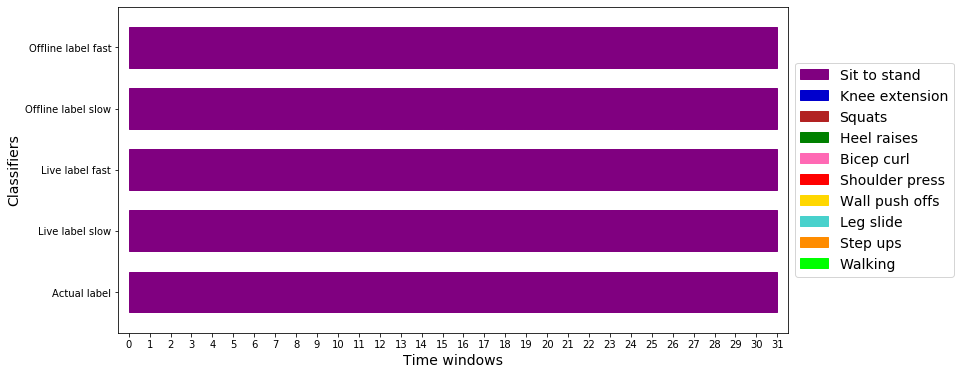

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Slow pred = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


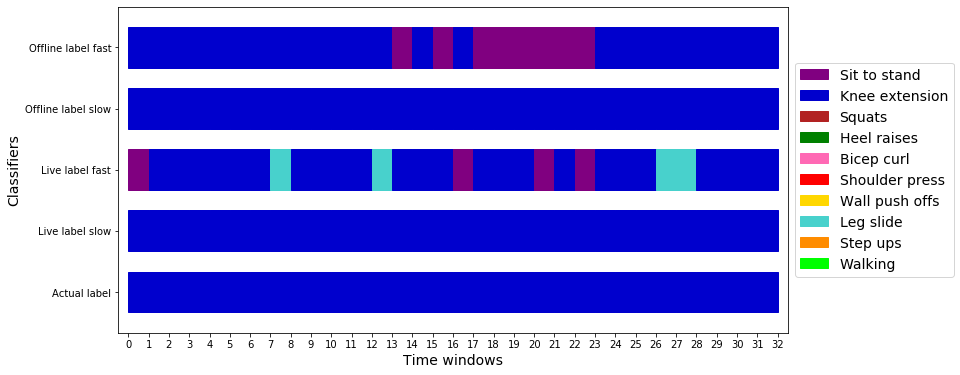

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [2 2 2 2 6 6 8 8 8 2 2 2 2 2 8 8 8 2 2 2 2 2 2 2 2 2 2 2 1 1 8 1]
Slow pred = [2 2 7 4 4 4 4 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2]


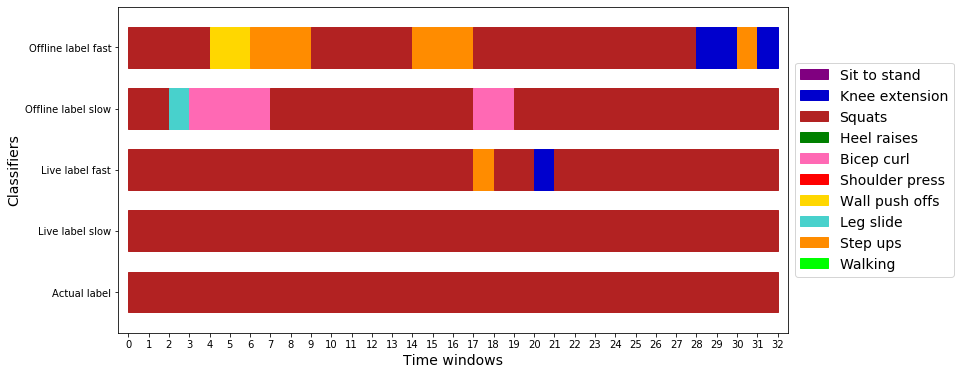

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [3 3 1 1 1 1 1 1 1 1 1 3 3 3 1 3 3 3 1 5 1 0 0 0 1 1 1 0 0 0 0 0]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


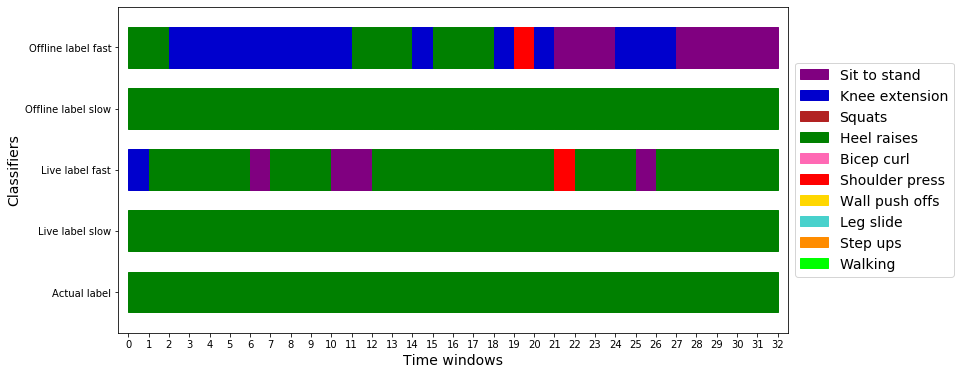

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4]


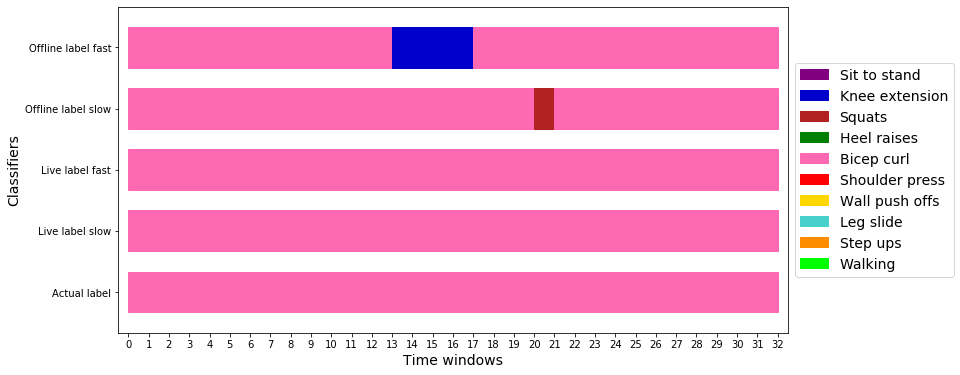

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


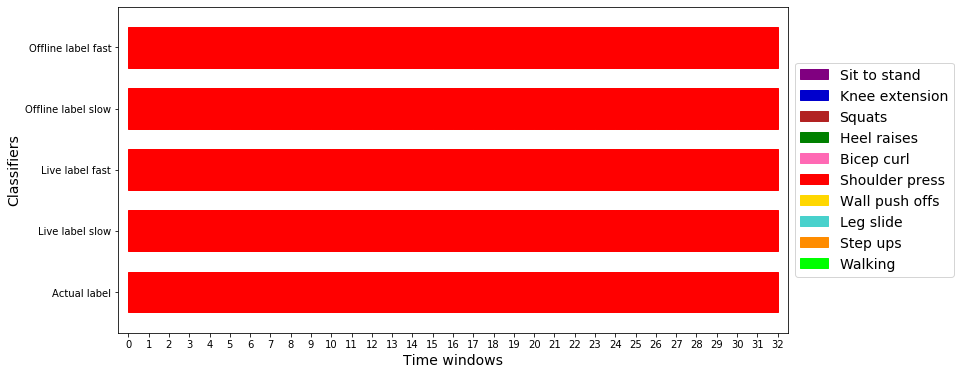

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 9 7 7 7 7 7 7 6 6 6 6 1 1 1 1 6 7 7 7 7 1 6 7 1 6 1 1 6 7 1 7]
Slow pred = [6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 6 1 1 6 1 6 6 6 6 6 1 6 6 6 6]


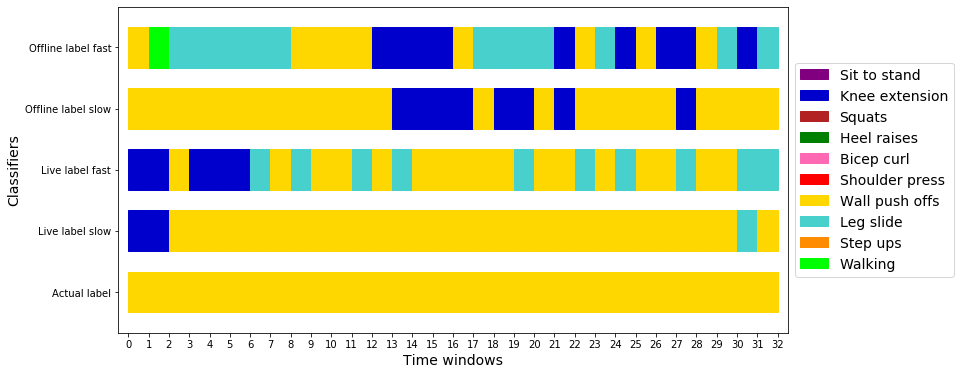

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [6 5 1 6 1 6 1 6 6 6 1 7 7 7 7 1 7 7 7 7 7 7 7 6 6 7 7 9 6 7 9 7]
Slow pred = [1 1 1 1 1 1 7 0 0 0 1 1 7 7 7 7 7 0 7 7 7 7 7 1 7 7 7 7 7 7 7 7]


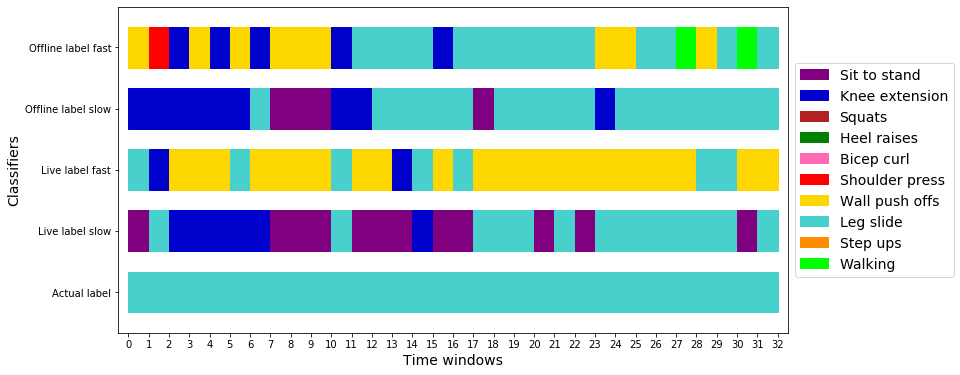

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [8 8 2 2 8 2 8 2 2 2 8 8 8 8 8 2 2 8 8 8 8 8 8 8 8 2 8]
Slow pred = [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 2 2 2 2 2 8]


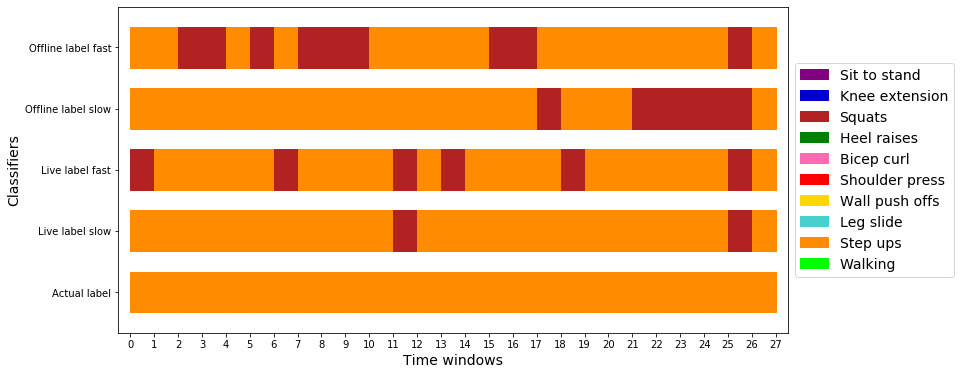

In [290]:
accuracies = plot_and_save(test_exercises, performed_exercises, "adela_slow")

In [291]:
accuracies

,Sit to stand,Knee extension,Squats,Heel raises,Bicep curl,Shoulder press,Wall push offs,Leg slide,Step ups,avg_accuracy,std_accuracy
online_fast,1.0,0.75,0.93750,0.8125,1.00000,1.0,0.53125,0.21875,0.777778,0.780864,0.261925
online_slow,1.0,1.00,1.00000,1.0000,1.00000,1.0,0.90625,0.43750,0.925926,0.918853,0.184194
offline_fast,1.0,0.75,0.62500,0.2500,0.87500,1.0,0.28125,0.46875,0.666667,0.657407,0.281705
offline_slow,1.0,1.00,0.78125,1.0000,0.96875,1.0,0.75000,0.59375,0.777778,0.874614,0.151763


In [292]:
adela_slow_walk = pd.read_csv("../Validation/adela_slow_walk.csv")

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 9
Fast pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


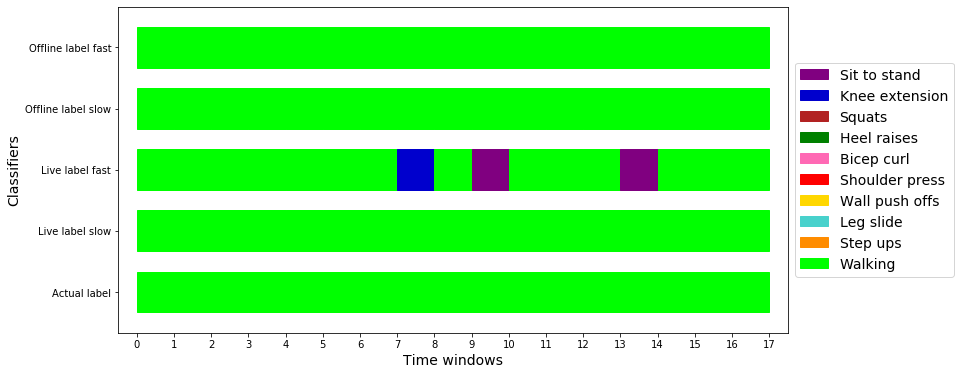

,Walking,avg_accuracy,std_accuracy
online_fast,0.823529,0.823529,NaN
online_slow,1.000000,1.000000,NaN
offline_fast,1.000000,1.000000,NaN
offline_slow,1.000000,1.000000,NaN


In [293]:
plot_and_save(adela_slow_walk, [9], "adela_slow_walk")

In [294]:
accuracies['Walking'] = [0.823529, 1.0, 1.0, 1.0]

In [295]:
accuracies.drop(columns=['avg_accuracy', 'std_accuracy'], inplace=True)

In [296]:
avg_accuracy = accuracies.mean(axis=1)
std_accuracy = accuracies.std(axis=1)
accuracies['avg_accuracy'] = avg_accuracy
accuracies['std_accuracy'] = std_accuracy

In [297]:
accuracies

,Sit to stand,Knee extension,Squats,Heel raises,Bicep curl,Shoulder press,Wall push offs,Leg slide,Step ups,Walking,avg_accuracy,std_accuracy
online_fast,1.0,0.75,0.93750,0.8125,1.00000,1.0,0.53125,0.21875,0.777778,0.823529,0.785131,0.247314
online_slow,1.0,1.00,1.00000,1.0000,1.00000,1.0,0.90625,0.43750,0.925926,1.000000,0.926968,0.175545
offline_fast,1.0,0.75,0.62500,0.2500,0.87500,1.0,0.28125,0.46875,0.666667,1.000000,0.691667,0.286840
offline_slow,1.0,1.00,0.78125,1.0000,0.96875,1.0,0.75000,0.59375,0.777778,1.000000,0.887153,0.148476


In [298]:
def get_accuracies_for_trials(list_of_file_names):
    all_accuracies = pd.DataFrame(columns=list(get_activity_name_dict().keys()))
    
    for file in list_of_file_names:
        print("*"*80)
        print("READING {}".format(file))
        print("*"*80)
        # load model
        final_model_no_outliers = load_model("./final_model_no_outliers.h5")

        # load test exercises file
        test_exercises = pd.read_csv("../Validation/{}".format(file))

        # extract the phone classifications
        indices = test_exercises[test_exercises['pred_fast'].notnull()].index.values
        values_fast = test_exercises[test_exercises['pred_fast'].notnull()]['pred_fast'].values
        values_slow = test_exercises[test_exercises['pred_fast'].notnull()]['pred_slow'].values
        actual_values = test_exercises[test_exercises['pred_fast'].notnull()]['actual_exercise'].values

        # get the list of performed exercises in the file
        performed_exercises = [int(i) for i in set(test_exercises[test_exercises['actual_exercise'].notnull()]['actual_exercise'].values)]

        # load the normaliser
        scaler_fit = pickle.load(open('scaler_fit.p', 'rb'))
        
        accuracies = plot_and_save(test_exercises, performed_exercises, "{}".format(file.split("/")[-1]))
        
        all_accuracies = pd.concat([all_accuracies, accuracies])
        
    return all_accuracies

In [301]:
file_list = os.listdir("../Validation/")
file_list = ["../Validation/" + i for i in file_list]
file_list

['../Validation/adela_slow_walk.csv',
 '../Validation/adela_fast_20200418T235020_exercises.csv',
 '../Validation/seb_fast_20200417T192757_exercises.csv',
 '../Validation/seb_shuffle_walk.csv',
 '../Validation/adela_fast_walk.csv',
 '../Validation/teo_shuffle_walk.csv',
 '../Validation/adela_shuffle_walk.csv',
 '../Validation/seb_slow_walk.csv',
 '../Validation/teo_fast_walk.csv',
 '../Validation/teo_wrong_exercises.csv',
 '../Validation/seb_slow_20200418T201303_exercises.csv',
 '../Validation/adela_slow_20200419T000043_exercises.csv',
 '../Validation/teo_fast_20200418T145608_exercises.csv',
 '../Validation/teo_slow_20200418T161741_exercises.csv',
 '../Validation/seb_fast_walk.csv',
 '../Validation/teo_slow_walk.csv']

********************************************************************************
READING ../Validation/adela_slow_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


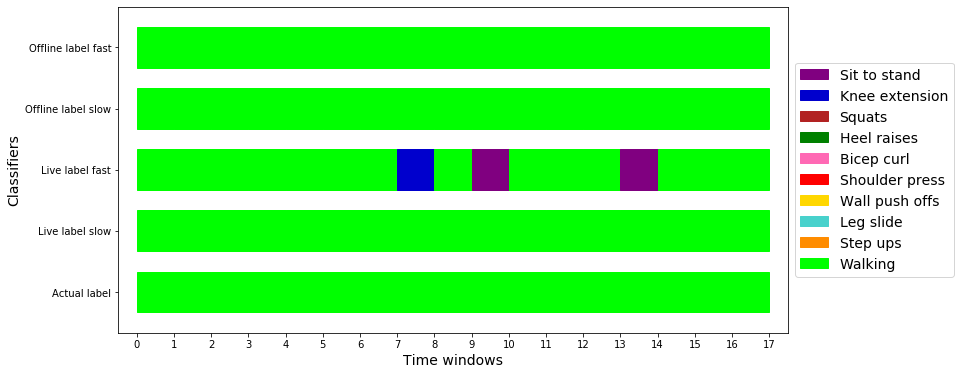

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/adela_fast_20200418T235020_exercises.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 0
Fast pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


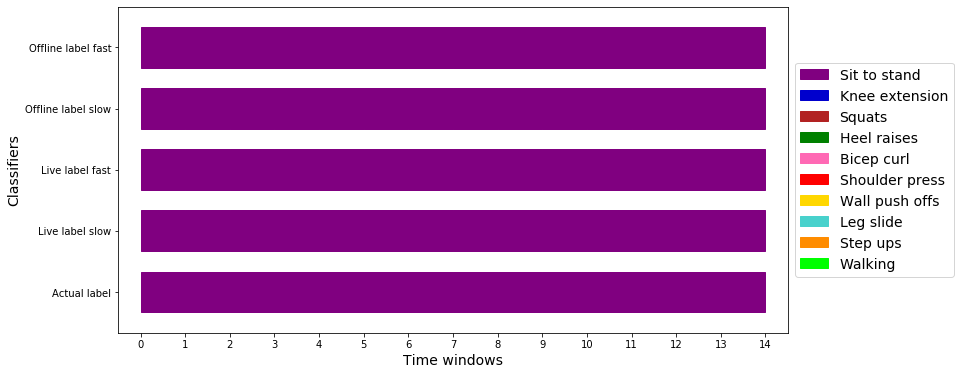

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [1 1 1 1 1 1 1 2 1 1 1 7 1 1]
Slow pred = [1 1 1 1 1 1 1 1 1 1 1 1 1 1]


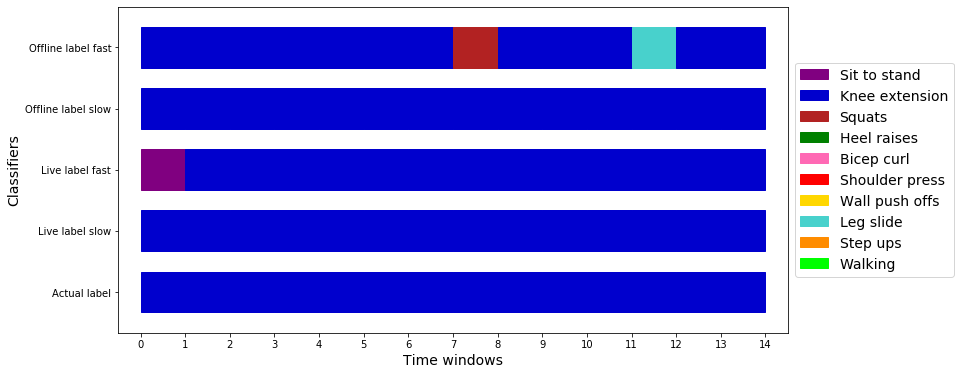

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [8 8 8 8 8 8 2 2 2 8 6 2 2 2]
Slow pred = [2 2 2 2 2 2 2 2 2 2 2 2 2 2]


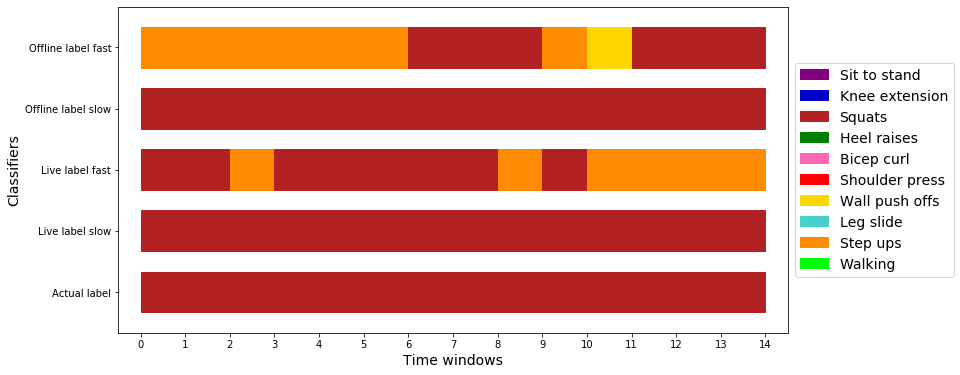

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [3 3 5 3 3 3 3 3 3 0 3 0 3 1]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3]


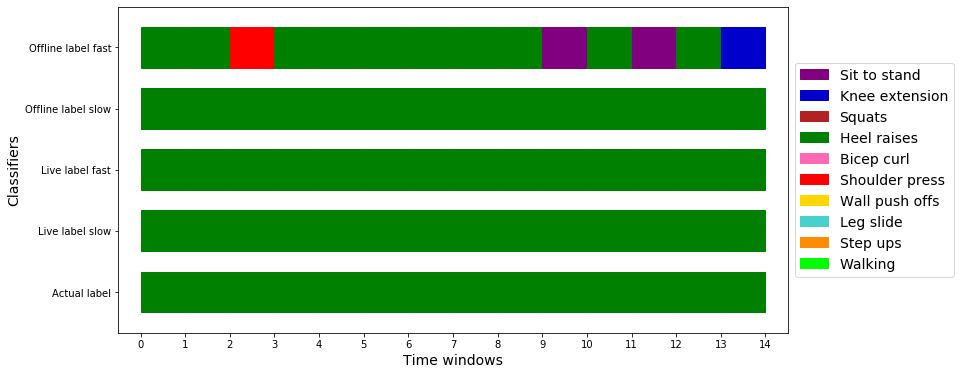

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4]


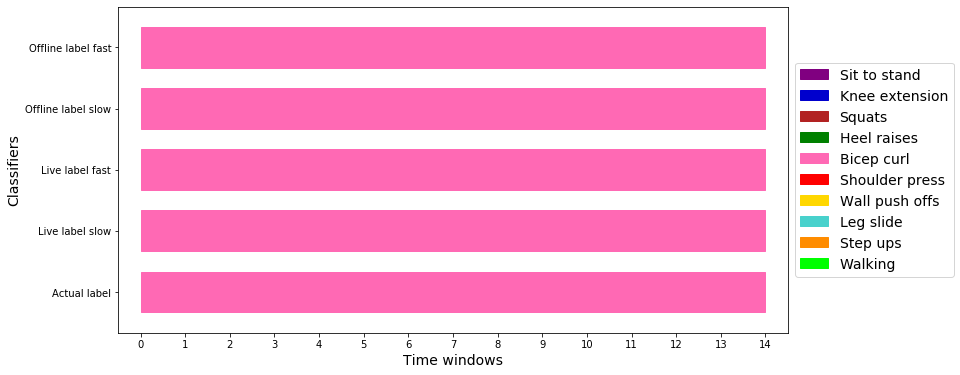

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 5 5 5 5 5 5 5]


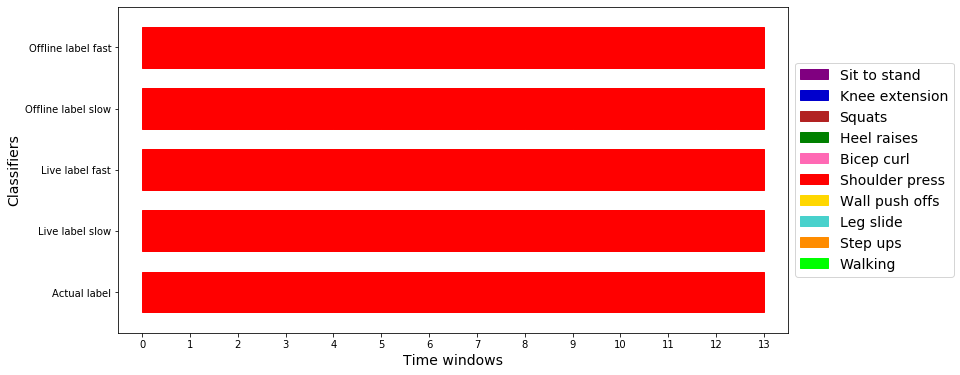

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 6 6 0 0 0 0 1 1 0 0 0 0 0]
Slow pred = [6 6 6 6 6 6 6 1 1 6 1 6 6 6]


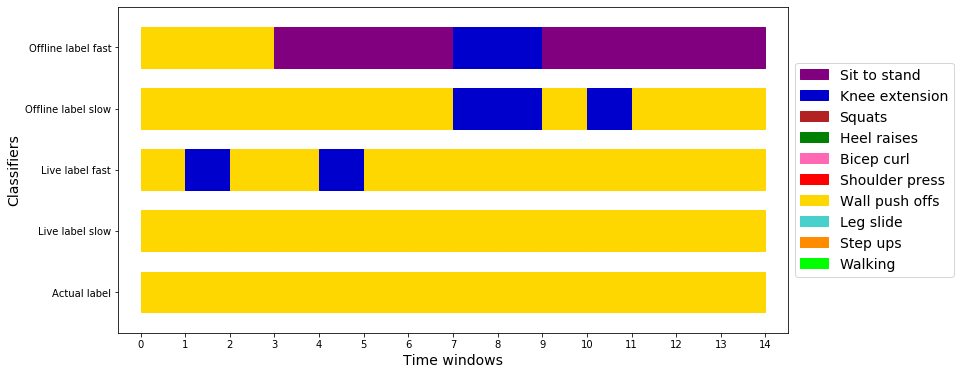

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [6 6 6 6 6 6 6 6 7 7 1 7 1 1]
Slow pred = [0 1 6 6 6 9 7 7 7 0 0 7 0 0]


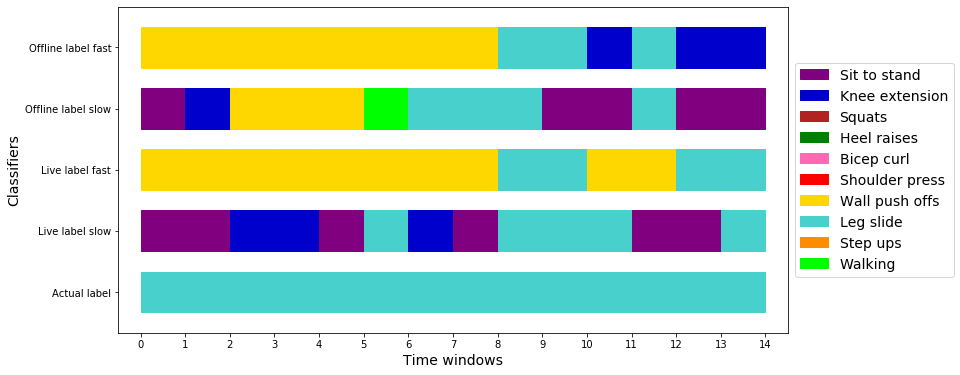

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [8 8 8 8 8 8 8 8 8]
Slow pred = [8 8 8 8 8 8 8 8 8]


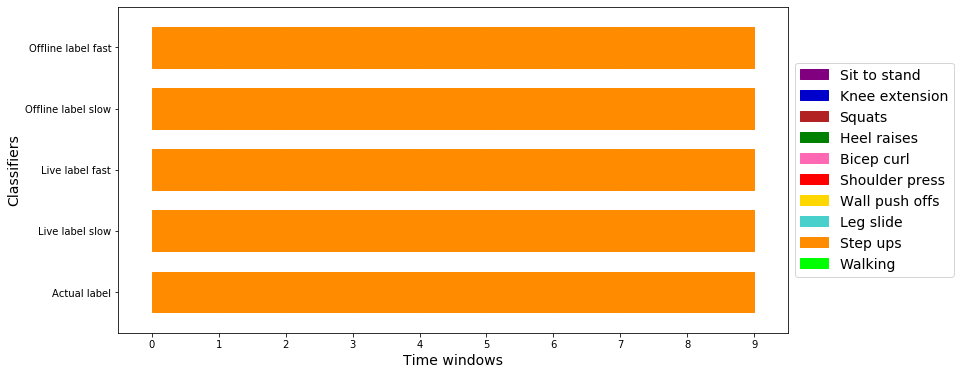

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/seb_fast_20200417T192757_exercises.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 0
Fast pred = [5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


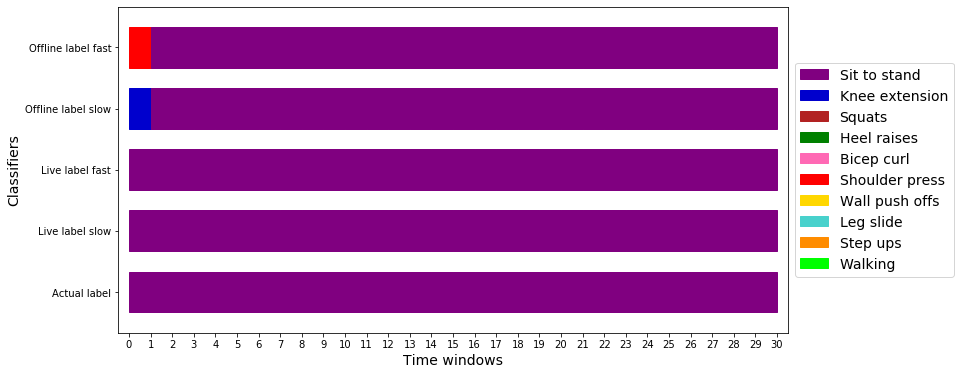

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [7 7 9 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]
Slow pred = [7 0 9 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


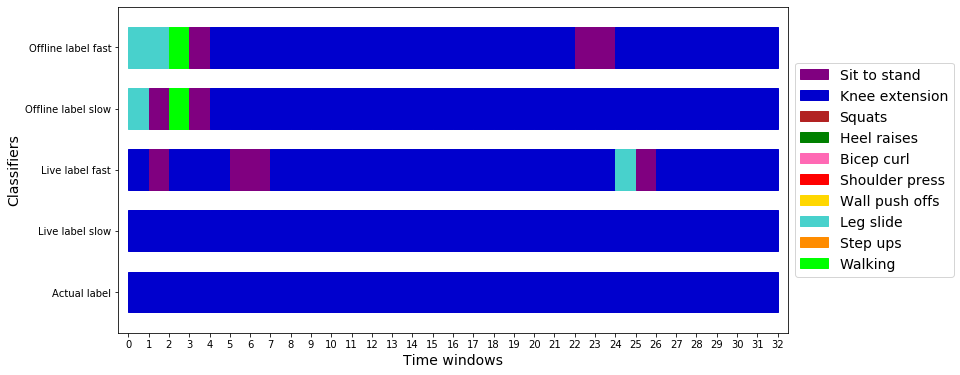

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [8 8 8 2 2 2 2 2 2 2 2 2 8 2 8 2 2 2 8 8 8 8 2 2 2 2 2 8 8 8 8 8]
Slow pred = [2 2 2 2 2 2 2 2 2 2 2 4 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


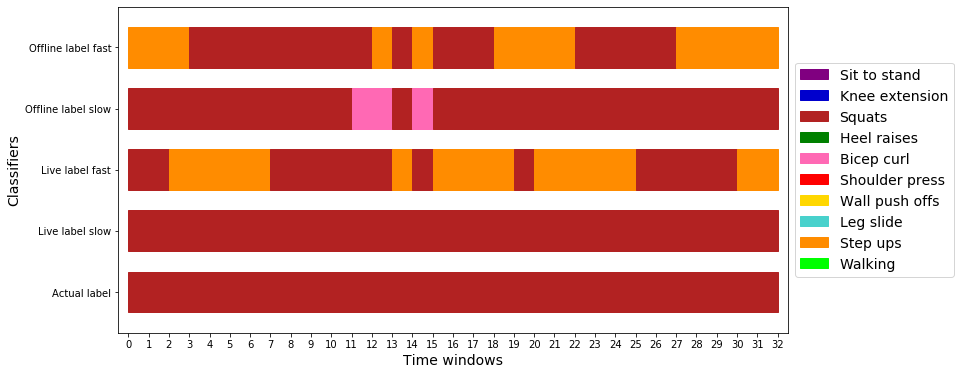

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [1 1 1 1 3 5 5 5 5 5 5 5 1 3 3 3 3 3 3 3 0 0 0 3 3 3 3 3 3 3 3 3]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


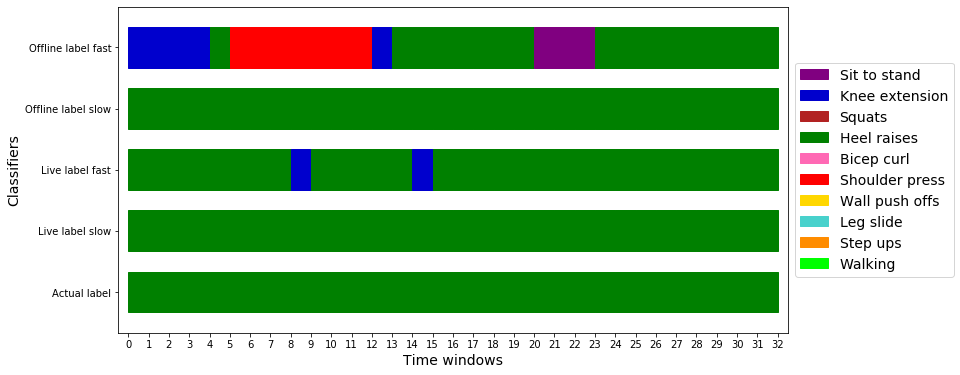

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 4 4 4 4 4 4 4 4 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


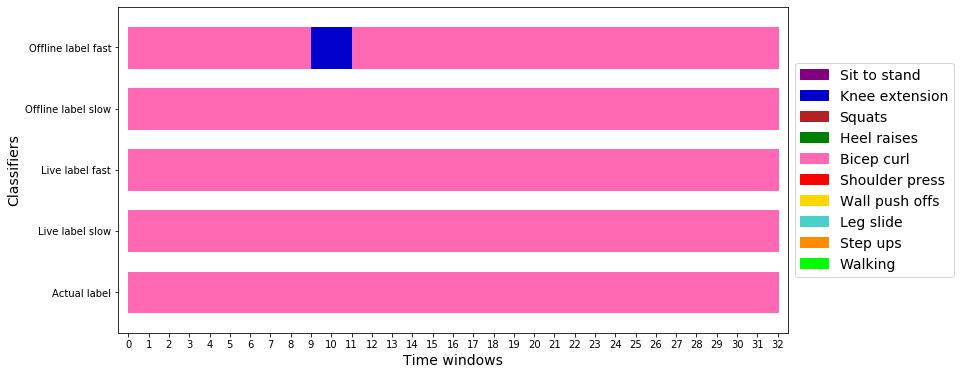

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


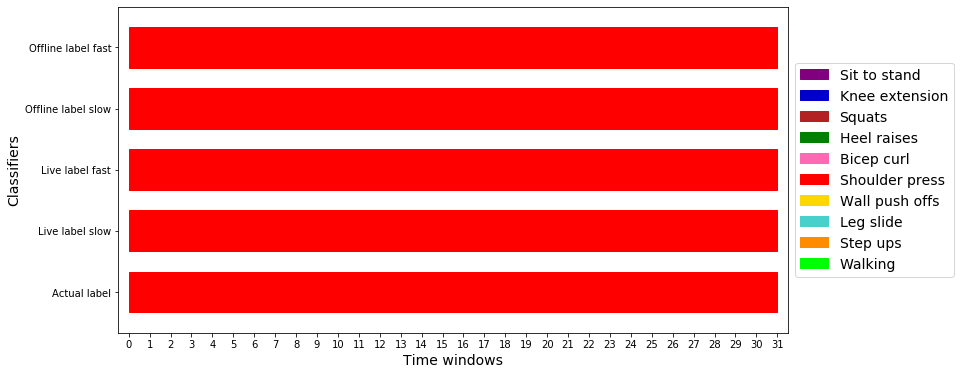

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Slow pred = [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


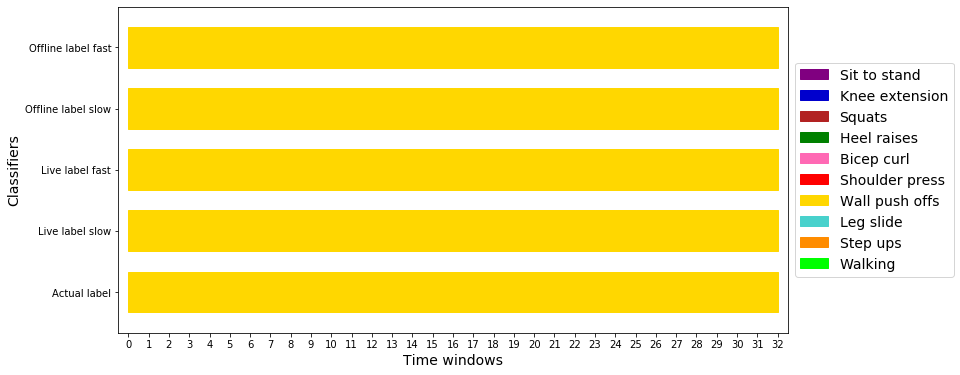

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [7 6 7 7 7 6 6 6 6 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 7]
Slow pred = [1 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 1 9 1 7 1 7]


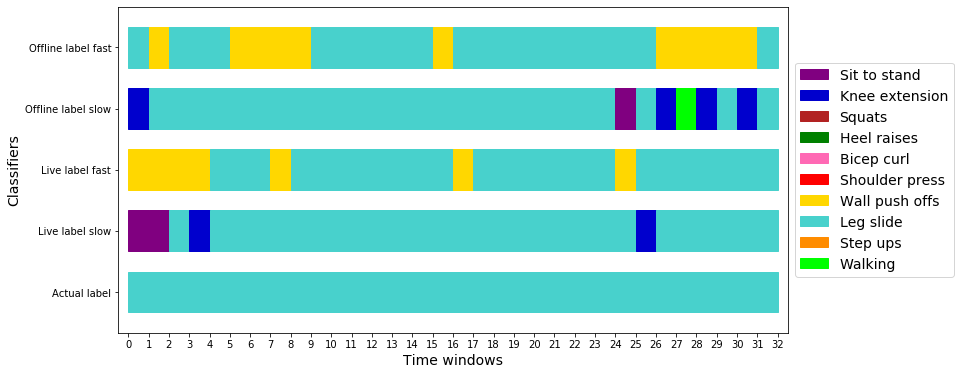

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [8 8 8 2 8 8 8 8 8 8 8 8 8 8 2 8 8 8 2 2 2 8 8 8 2 2 8 8 8]
Slow pred = [2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


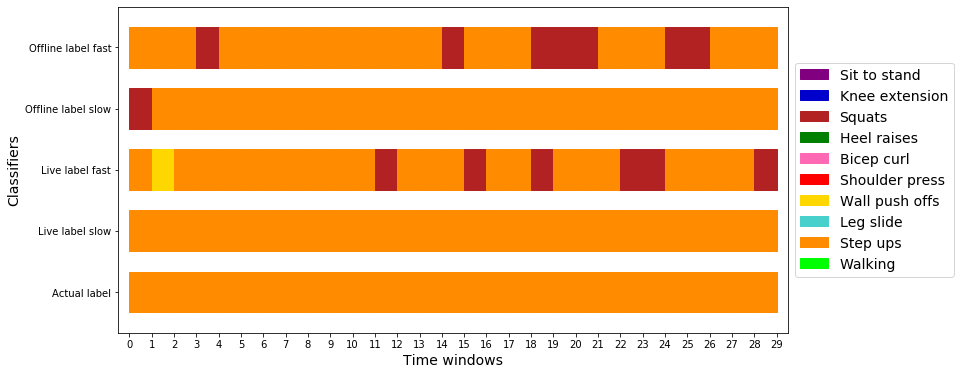

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/seb_shuffle_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


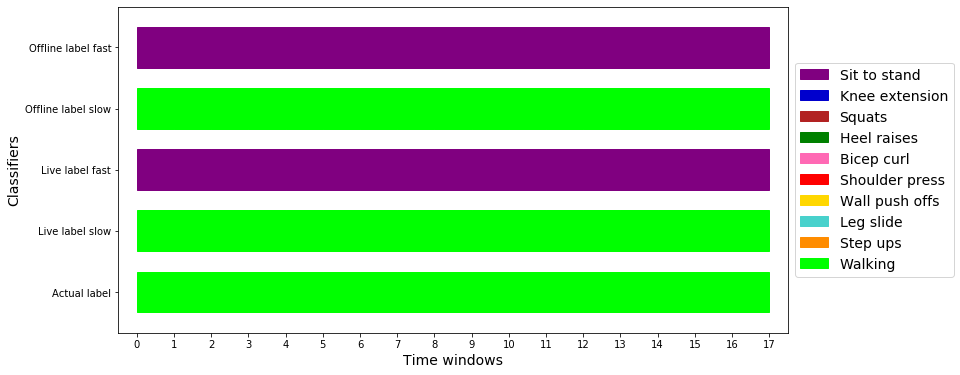

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/adela_fast_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


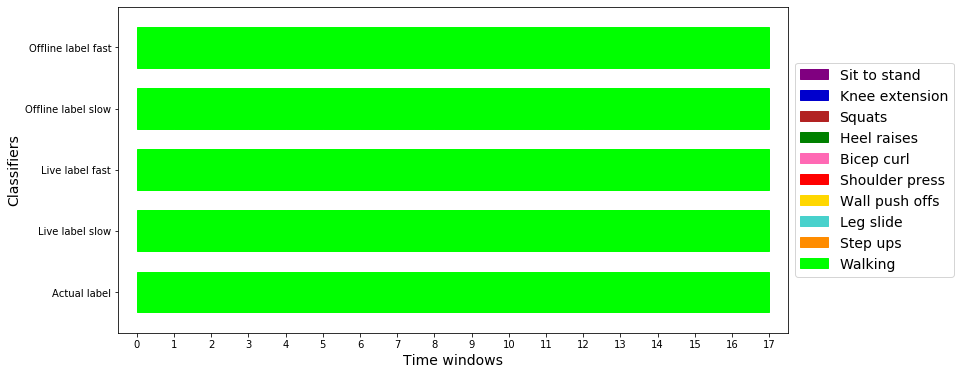

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/teo_shuffle_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [5 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


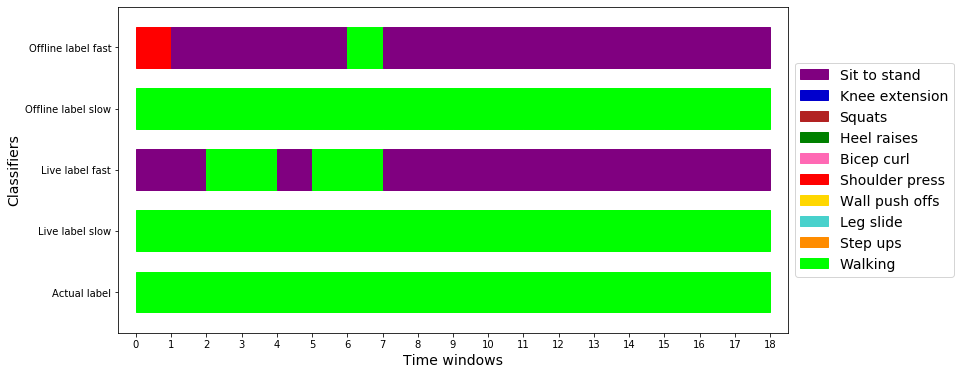

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/adela_shuffle_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [9 9 9 9 9 9 0 9 9 9 9 9 9 9 0 0 9 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


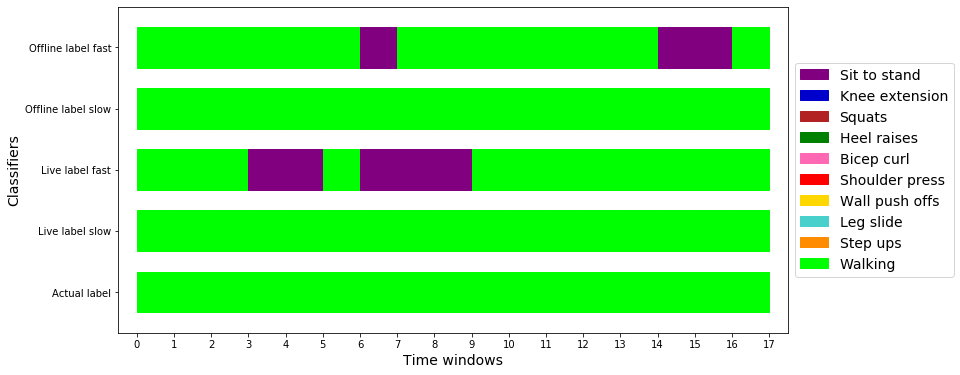

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/seb_slow_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


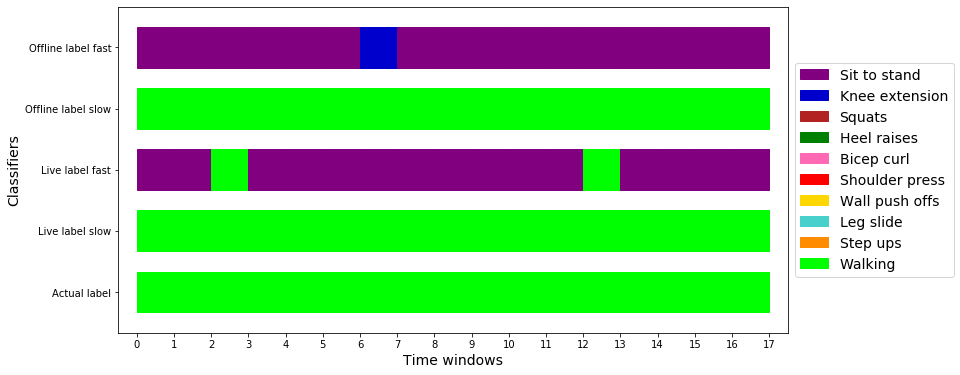

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/teo_fast_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


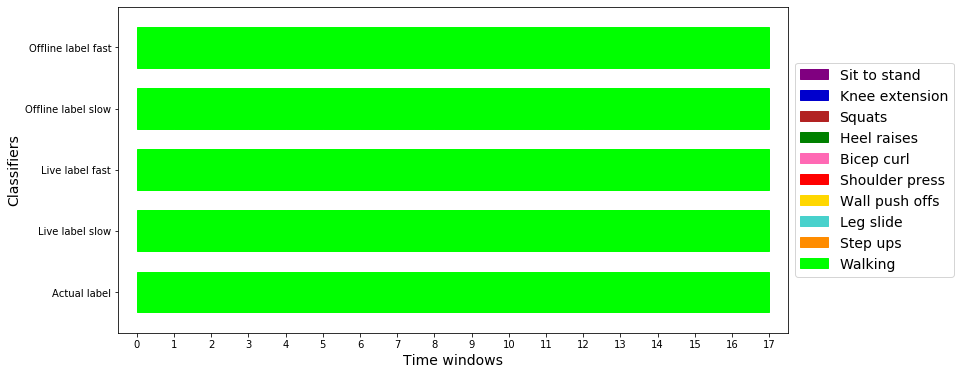

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/teo_wrong_exercises.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 0
Fast pred = [0 0 0 0 0 0 0 0 0 0 9 9 9 0]
Slow pred = [0 0 0 0 0 0 0 0 0 0 9 9 9 9]


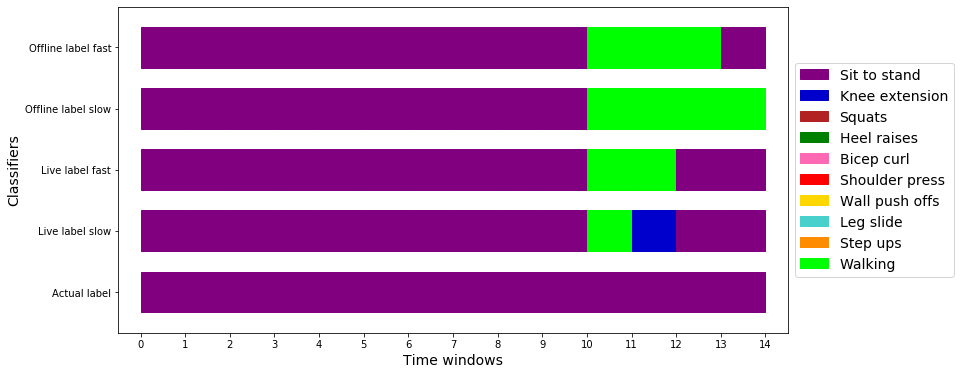

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [1 1 1 9 1 9 1 1 1 1 1 1 1 1]
Slow pred = [1 1 1 1 1 1 1 1 1 1 1 1 1 1]


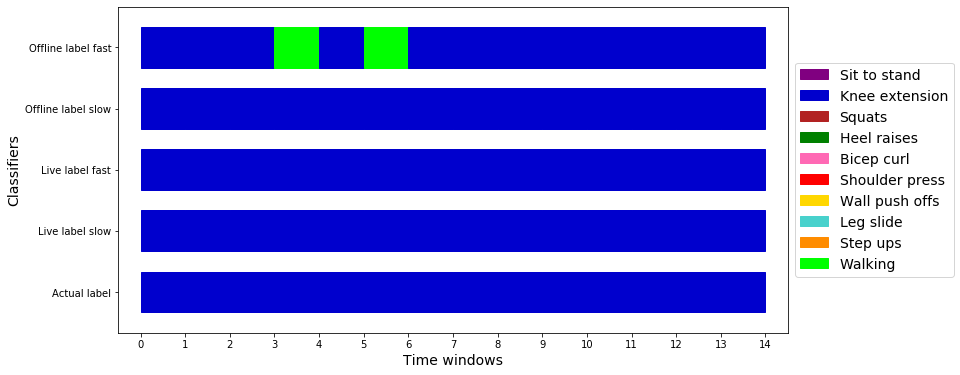

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [2 2 1 1 1 1 8 8 8 2 2 2 2 2]
Slow pred = [2 2 2 2 2 2 2 2 2 2 2 2 4 4]


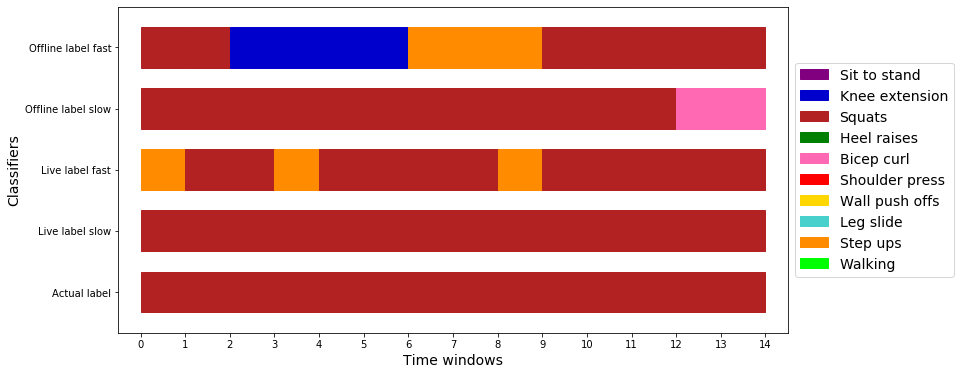

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [1 1 2 2 2 2 5 0 0 0 0 0 0 0]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3]


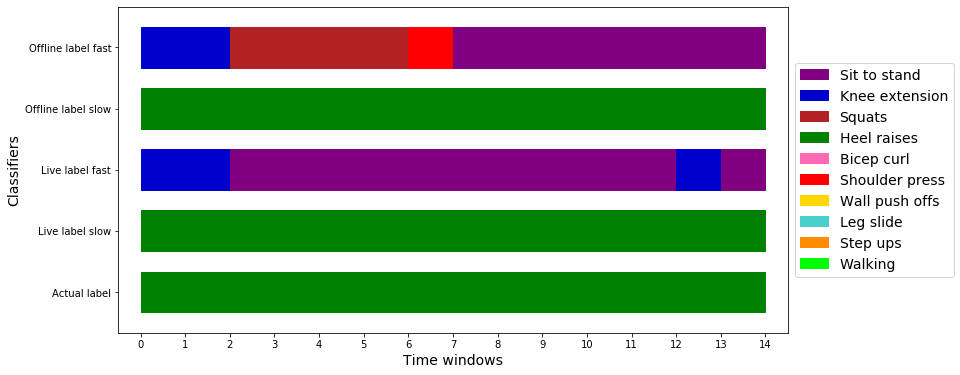

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4]


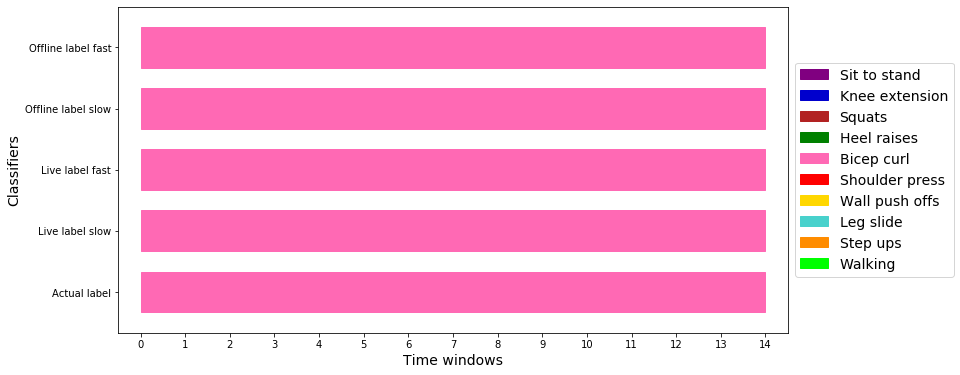

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5]


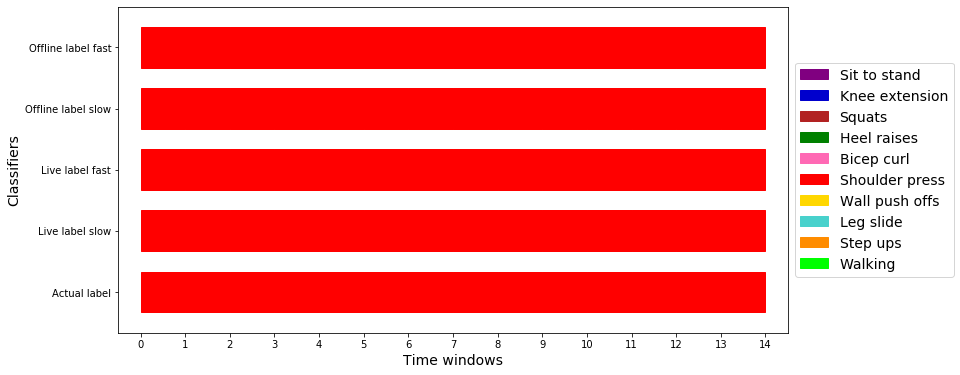

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 6 7 7 6 1 7 1 9 4 0 1 1 1]
Slow pred = [6 6 6 6 6 6 6 1 1 1 1 1 1 1]


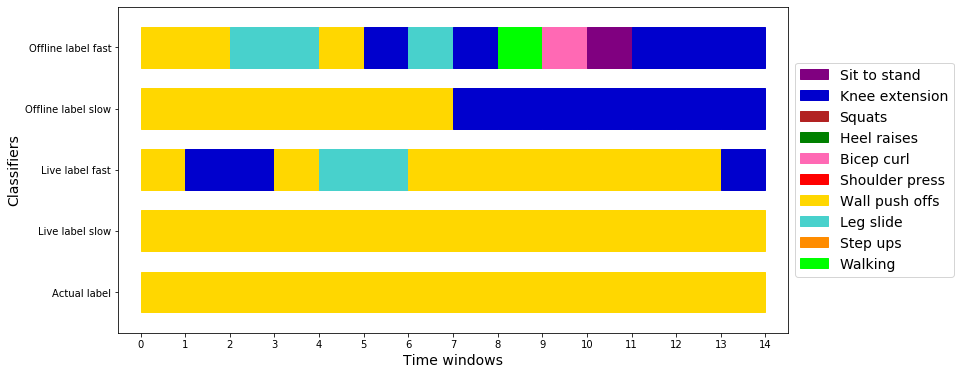

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [1 1 1 1 1 1 1 1 1 1 1 7 7 6]
Slow pred = [0 0 0 0 1 1 7 7 0 0 0 7 7 6]


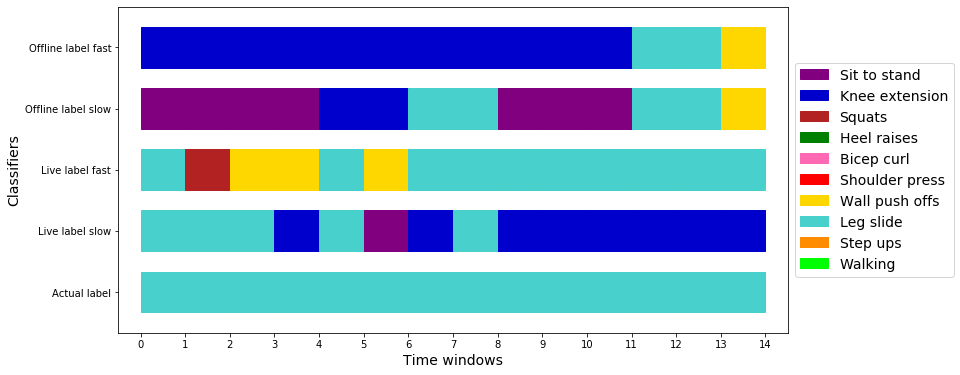

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [4 8 8 8 8 8 8 8 8 8 8 8 8 8]
Slow pred = [1 1 8 8 8 8 8 8 8 8 8 8 8 8]


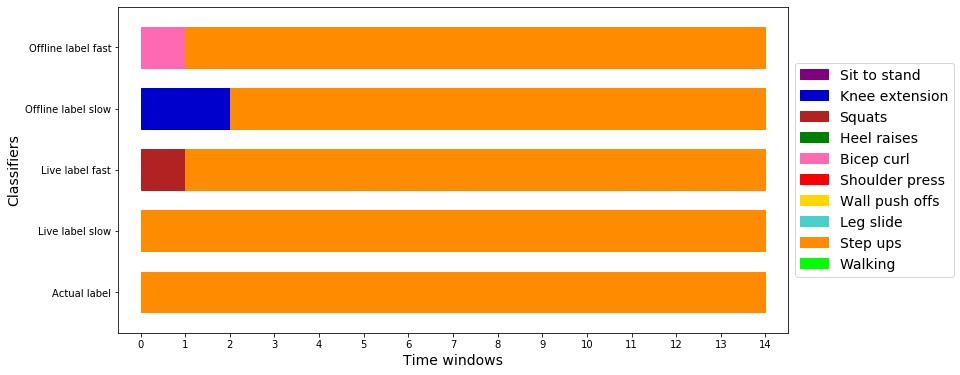

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 9
Fast pred = [5 5 0 0 0 0 0 7 9 9 9 0 0 0 0 0 0 0]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


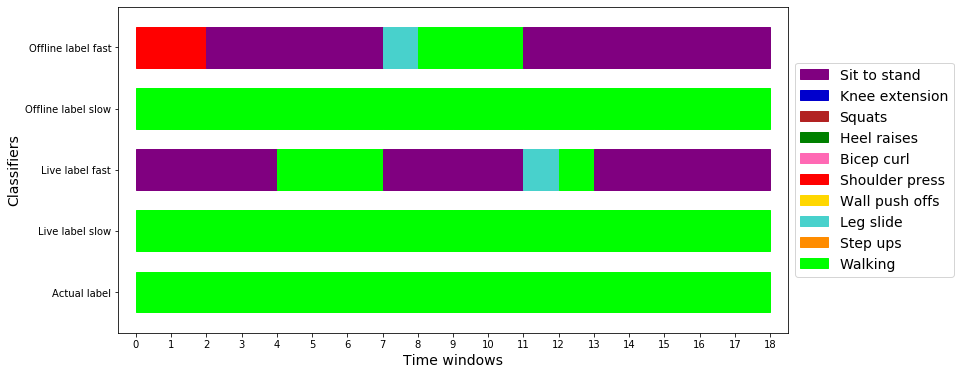

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/seb_slow_20200418T201303_exercises.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 0
Fast pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


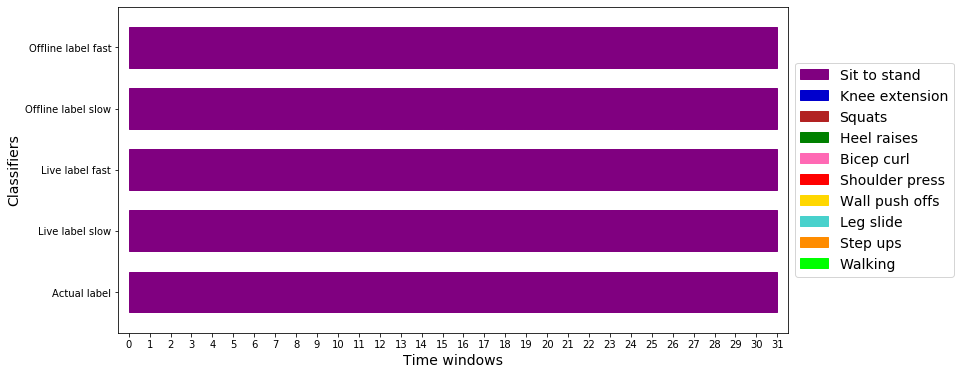

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [6 6 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Slow pred = [6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


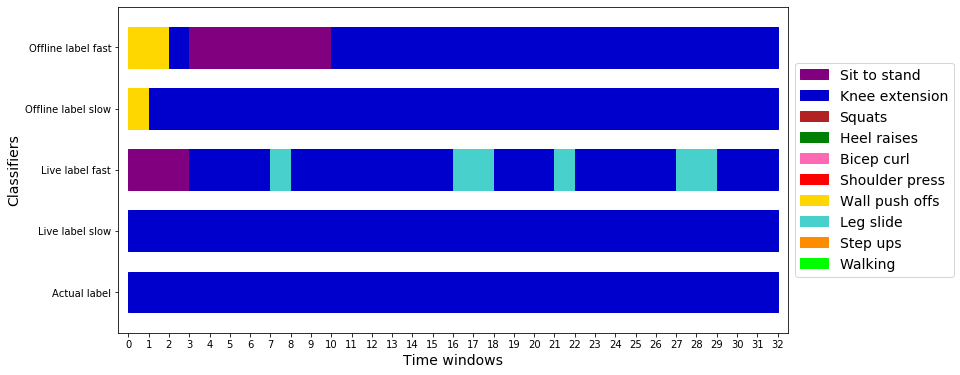

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [2 2 2 2 2 2 2 2 2 2 2 8 8 6 8 2 2 2 2 2 1 8 8 8 8 2 2 2 2 2 2 2]
Slow pred = [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


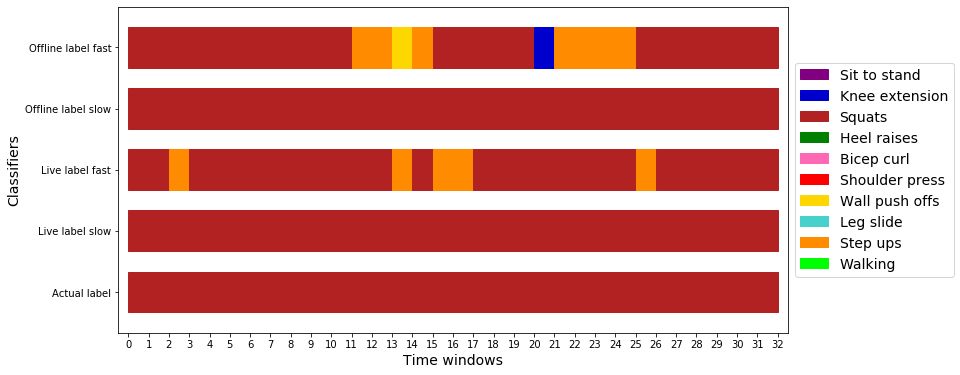

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [0 1 3 1 3 3 1 3 0 3 3 0 0 0 3 3 5 3 3 3 1 1 3 1 1 3 1 1 3 1 1 1]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


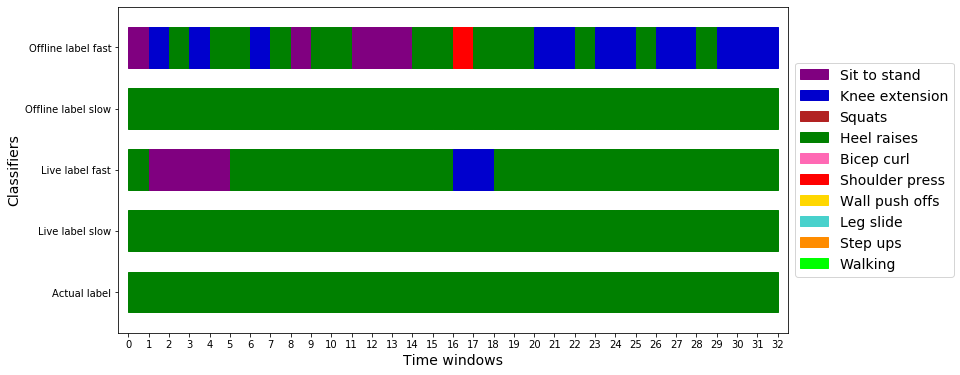

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


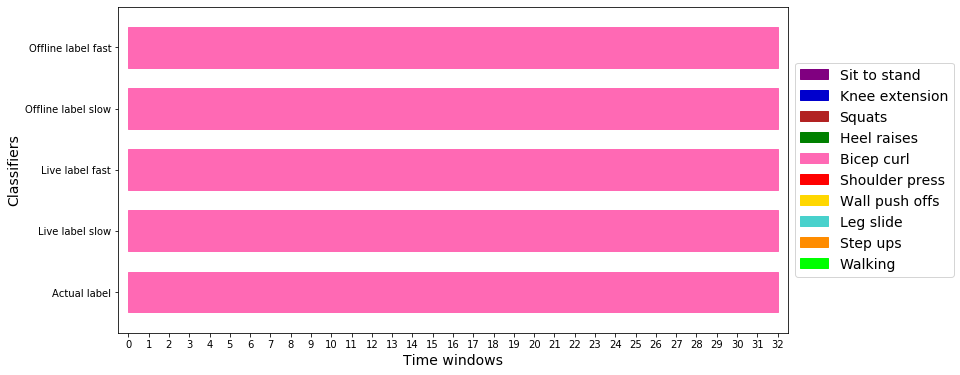

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5]


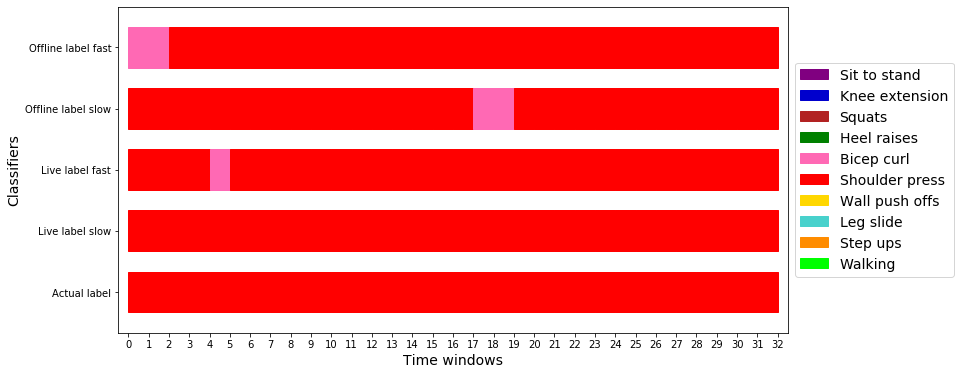

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 6 6 0 0 0 0 0 0 0 0 7 7 0 7 6 6 6 0 0 0 0 0 1 0 0 0 6 0 0 0 0]
Slow pred = [6 6 6 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 1 1 6 1 1 6 6 6 6 1 1 6]


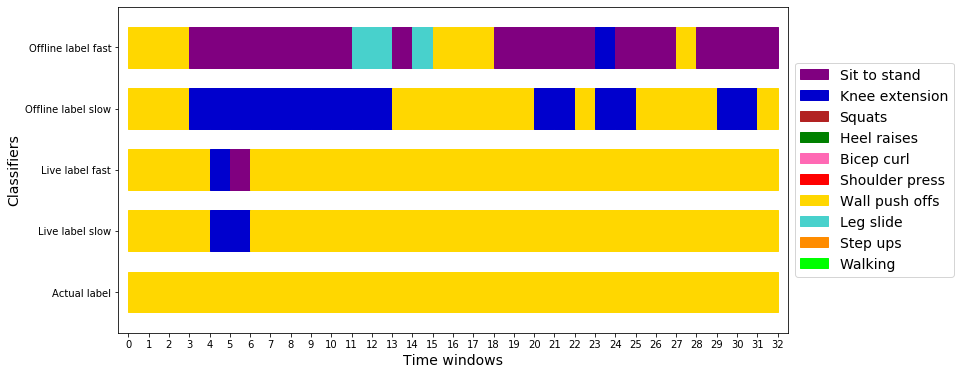

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [6 6 6 7 7 6 6 1 6 7 1 7 7 7 7 1 7 7 2 7 7 6 6 6 6 6 6 6 6 6 7]
Slow pred = [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 6 7 6 6 7 1 7 7 7]


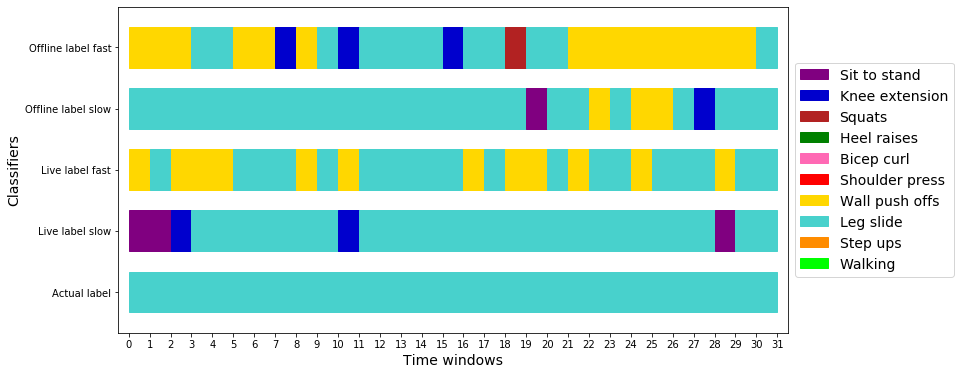

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [2 8 8 8 8 8 8 8 8 8 2 2 8 8 8 8 6 6 8 2 8 8 8 8 8 8 8 8]
Slow pred = [8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


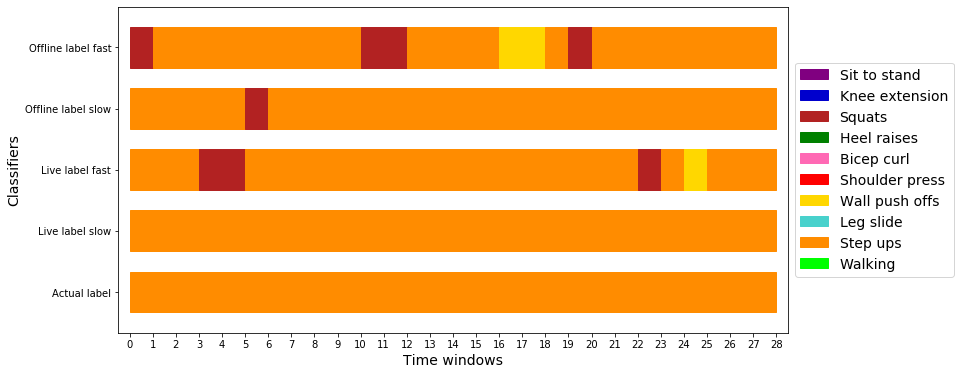

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/adela_slow_20200419T000043_exercises.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 0
Fast pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


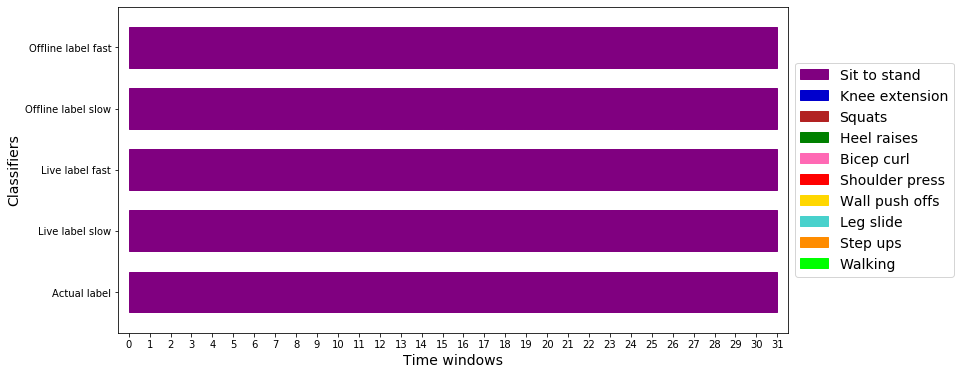

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Slow pred = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


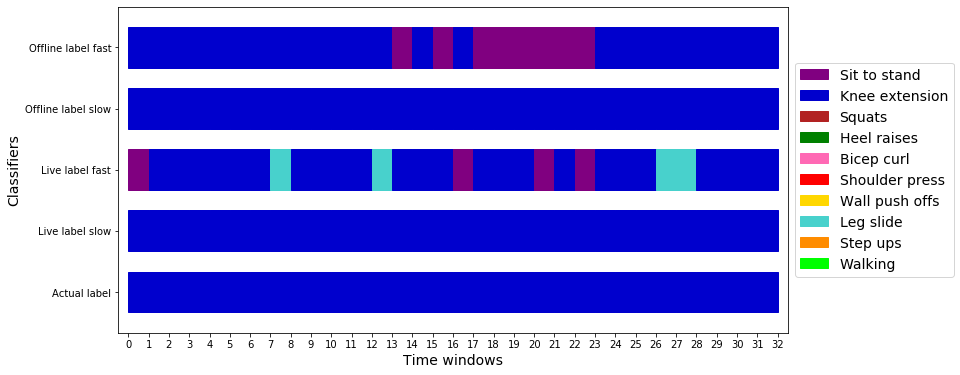

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [2 2 2 2 6 6 8 8 8 2 2 2 2 2 8 8 8 2 2 2 2 2 2 2 2 2 2 2 1 1 8 1]
Slow pred = [2 2 7 4 4 4 4 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2]


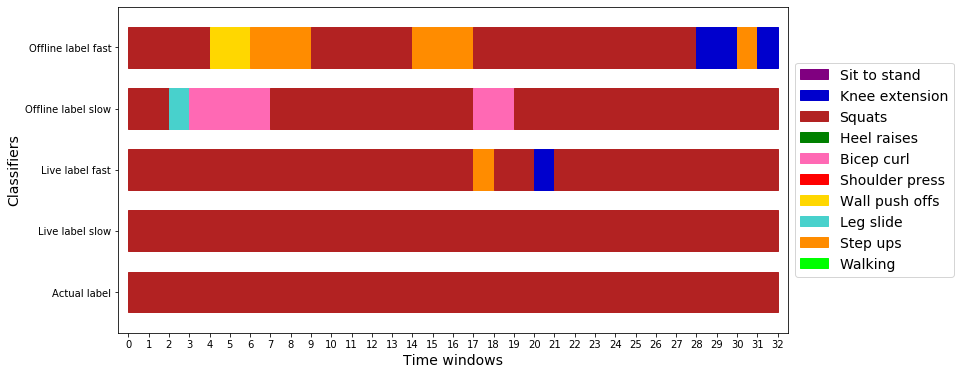

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [3 3 1 1 1 1 1 1 1 1 1 3 3 3 1 3 3 3 1 5 1 0 0 0 1 1 1 0 0 0 0 0]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


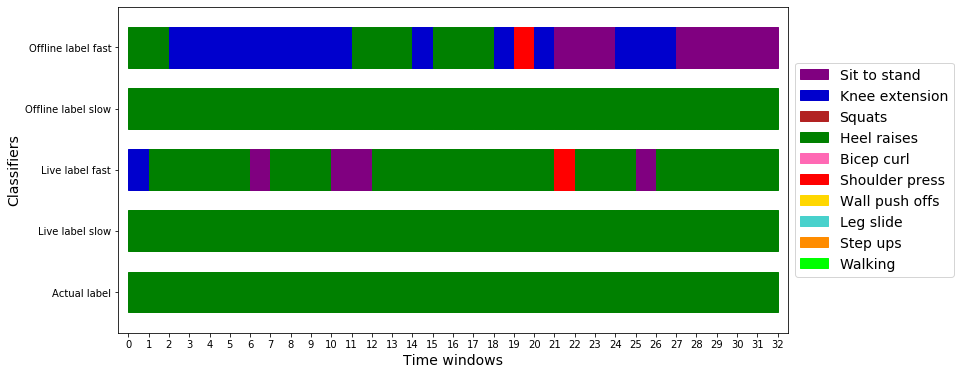

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4]


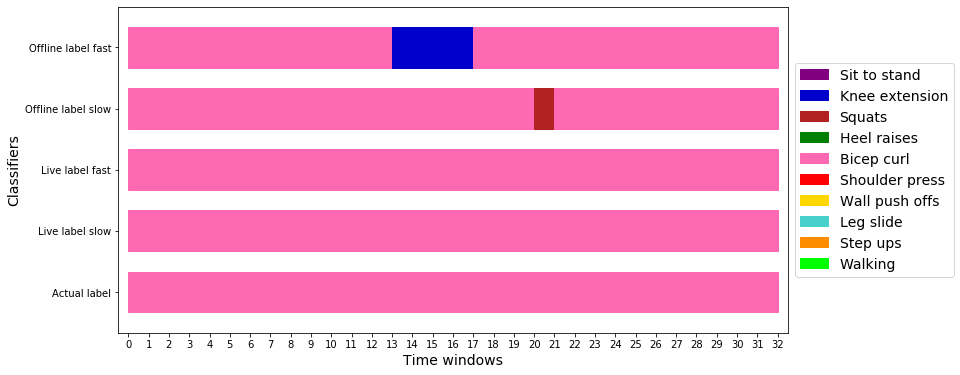

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


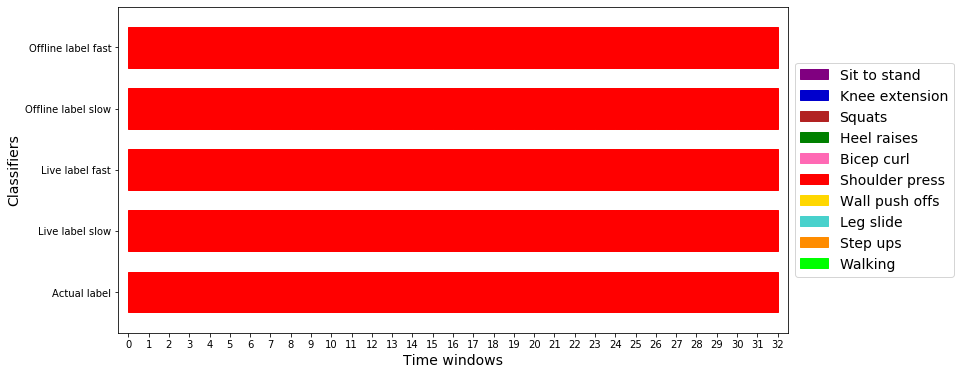

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 9 7 7 7 7 7 7 6 6 6 6 1 1 1 1 6 7 7 7 7 1 6 7 1 6 1 1 6 7 1 7]
Slow pred = [6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 6 1 1 6 1 6 6 6 6 6 1 6 6 6 6]


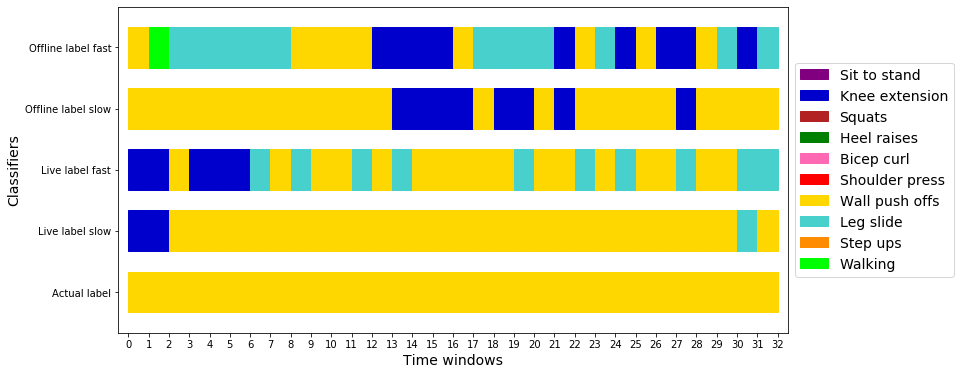

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [6 5 1 6 1 6 1 6 6 6 1 7 7 7 7 1 7 7 7 7 7 7 7 6 6 7 7 9 6 7 9 7]
Slow pred = [1 1 1 1 1 1 7 0 0 0 1 1 7 7 7 7 7 0 7 7 7 7 7 1 7 7 7 7 7 7 7 7]


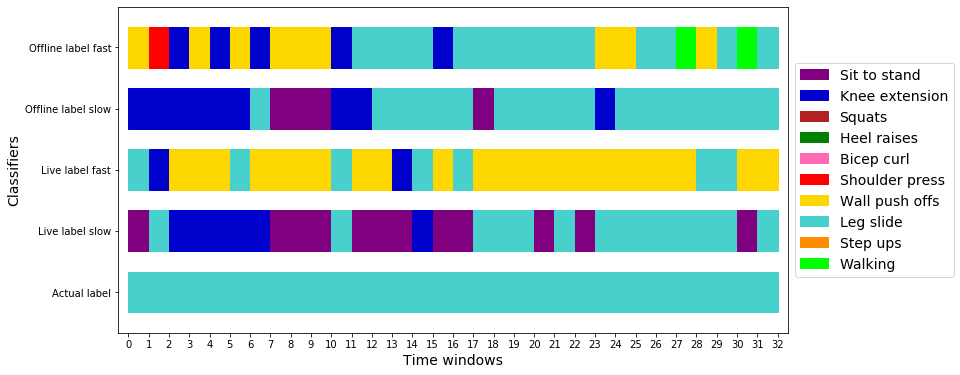

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [8 8 2 2 8 2 8 2 2 2 8 8 8 8 8 2 2 8 8 8 8 8 8 8 8 2 8]
Slow pred = [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 2 2 2 2 2 8]


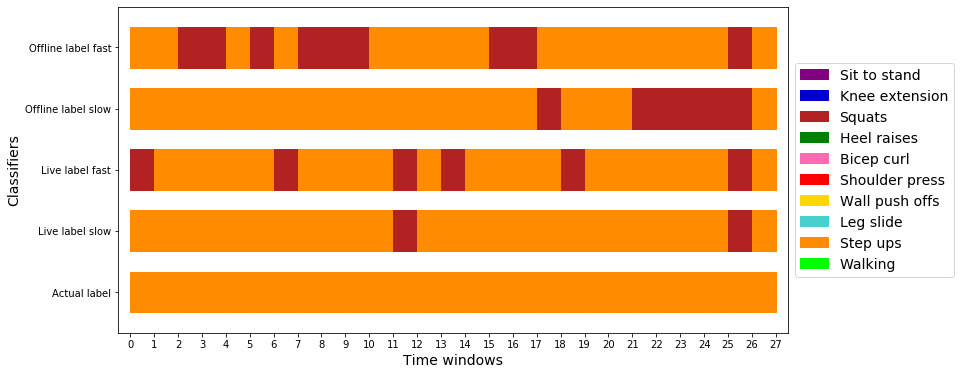

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/teo_fast_20200418T145608_exercises.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 0
Fast pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


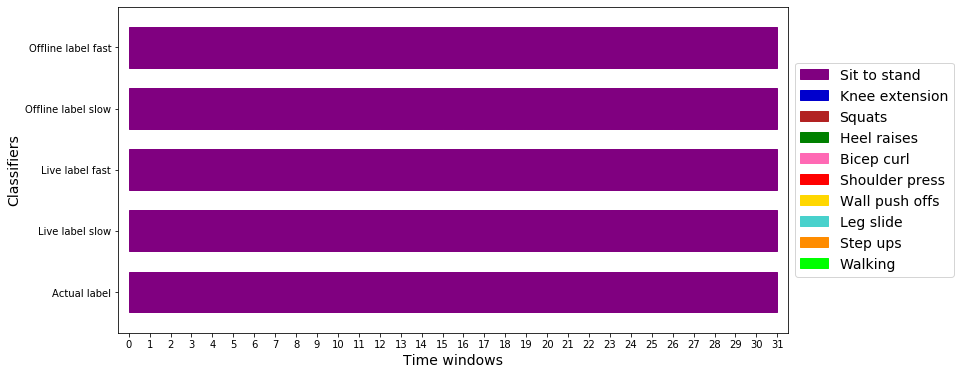

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [9 9 9 9 9 1 1 1 1 1 1 1 1 1 1 9 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Slow pred = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


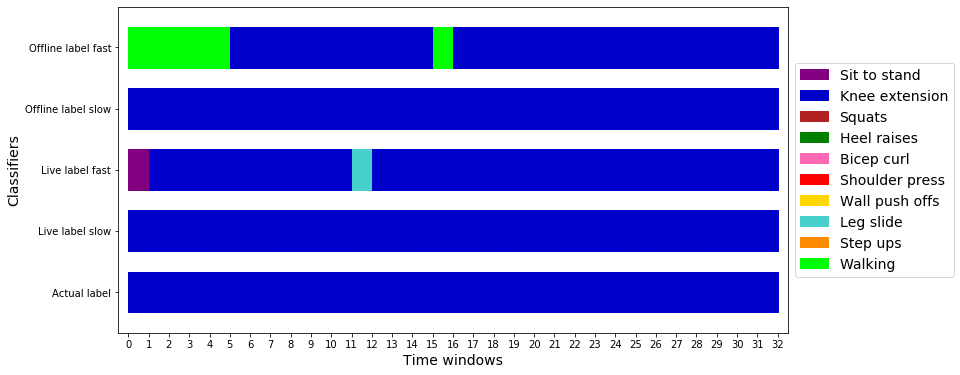

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [2 2 2 2 2 2 2 8 2 2 2 2 2 2 8 8 8 8 8 2 2 8 8 8 2 8 8 2 2 2 8 8]
Slow pred = [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


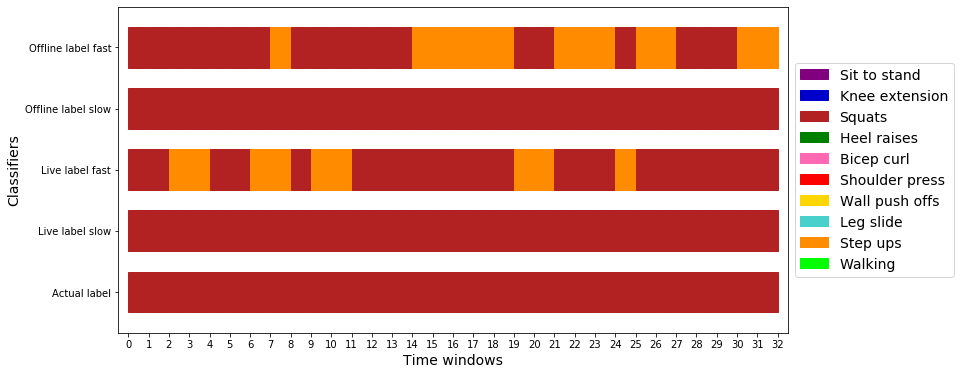

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [5 0 0 0 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5]


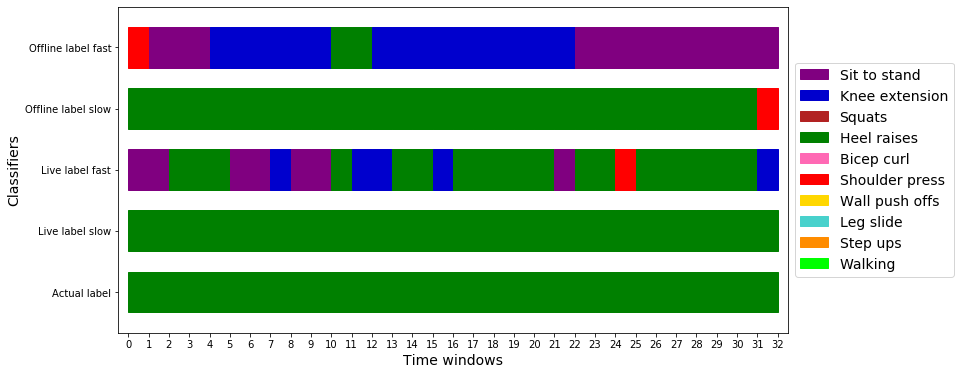

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


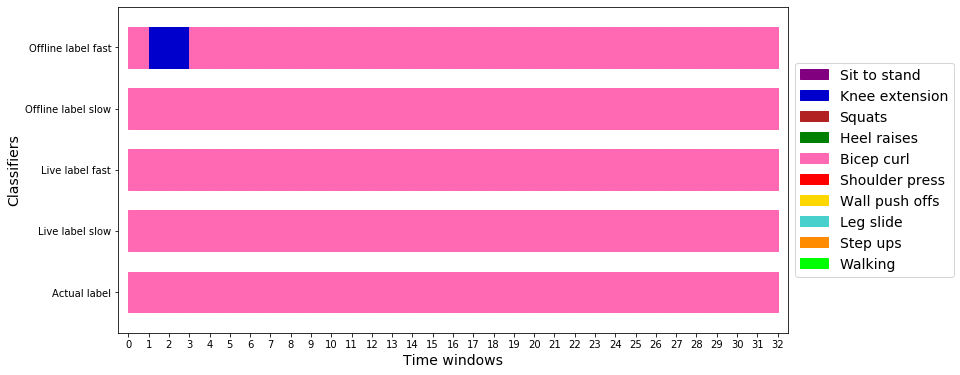

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


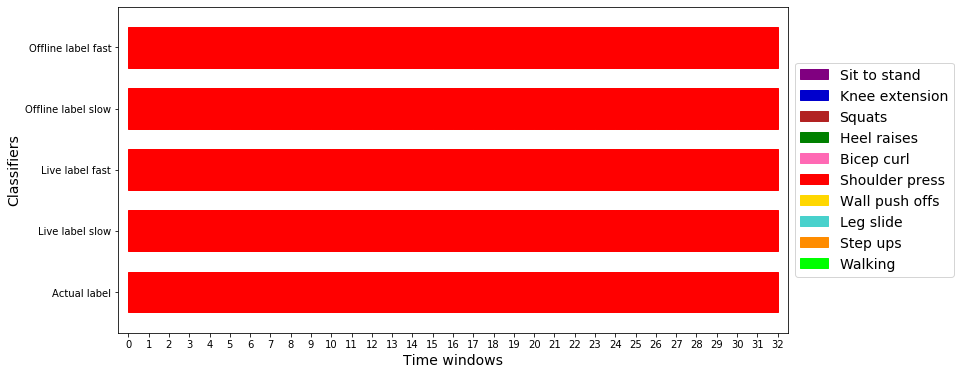

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 6 0 6 6 6 6 6 6 6 6 6 6 0 6 6 6 6 6 6 6 6 6 6 6 6 0 0 6 6 6 6]
Slow pred = [6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


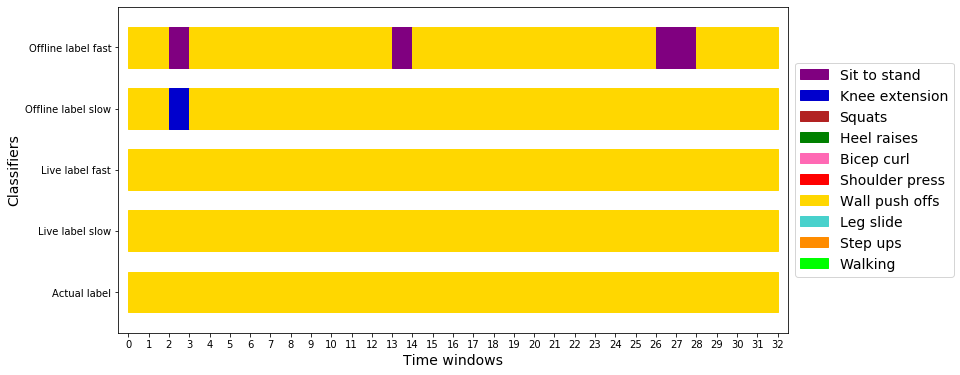

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [6 6 6 6 6 6 6 6 6 6 7 6 6 6 7 7 7 7 6 6 6 7 7 7 7 7 6 7 7 7 6 6]
Slow pred = [6 6 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 7 7 0 0 7 7 7 0 0]


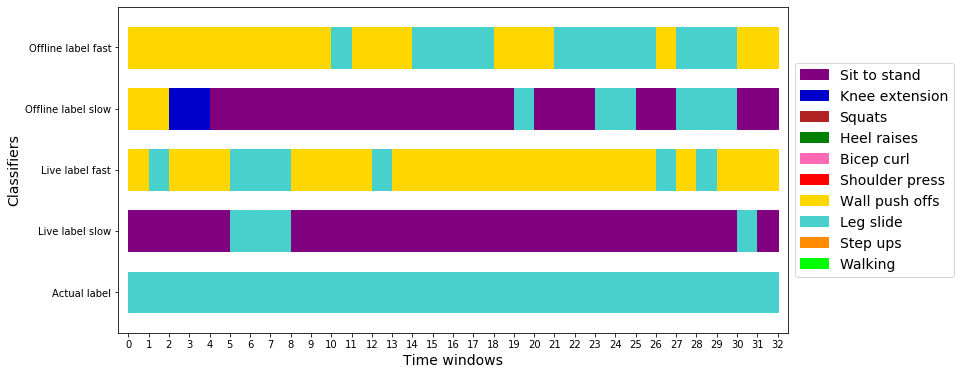

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Slow pred = [8 2 2 2 2 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


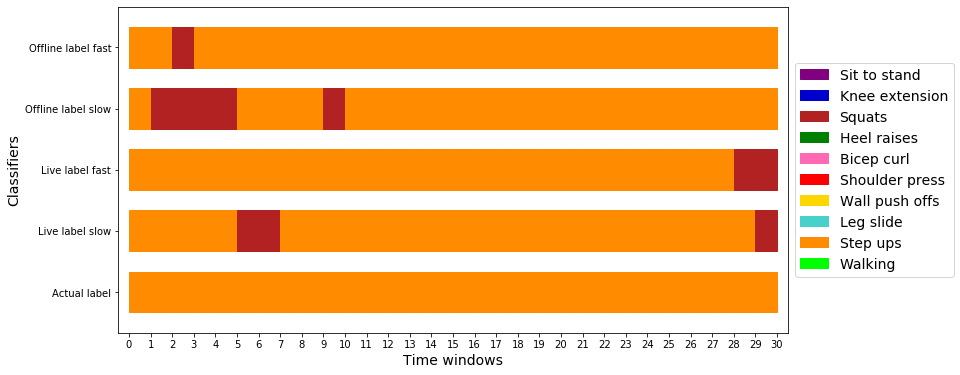

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/teo_slow_20200418T161741_exercises.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 0
Fast pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Slow pred = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


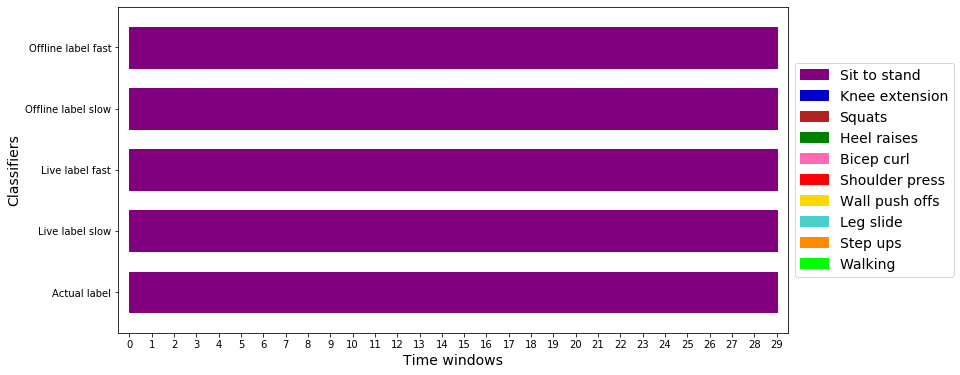

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 1
Fast pred = [6 7 0 7 0 9 0 0 0 0 0 0 0 9 0 1 1 6 1 1 1 1 1 1 1 1 1 1 6 6 6 1]
Slow pred = [1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


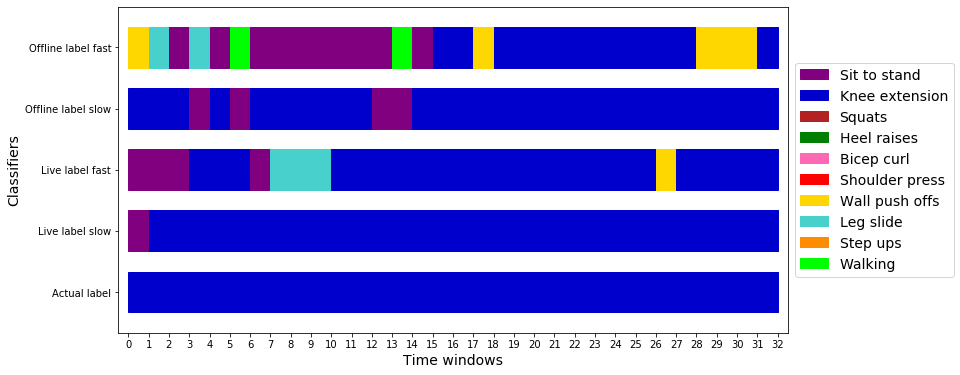

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 2
Fast pred = [2 2 2 2 2 8 6 8 8 2 2 2 2 8 2 8 8 2 2 2 2 2 8 8 6 6 2 4 2 2 2 2]
Slow pred = [6 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


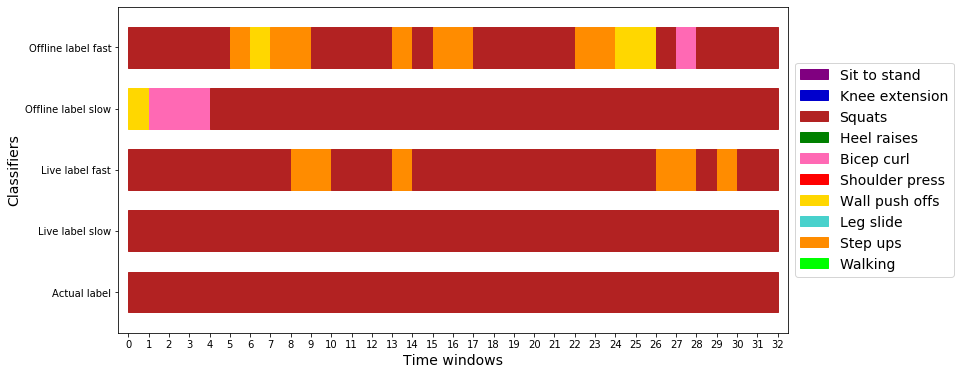

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 3
Fast pred = [5 5 5 5 5 1 1 1 1 1 5 5 5 9 9 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
Slow pred = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


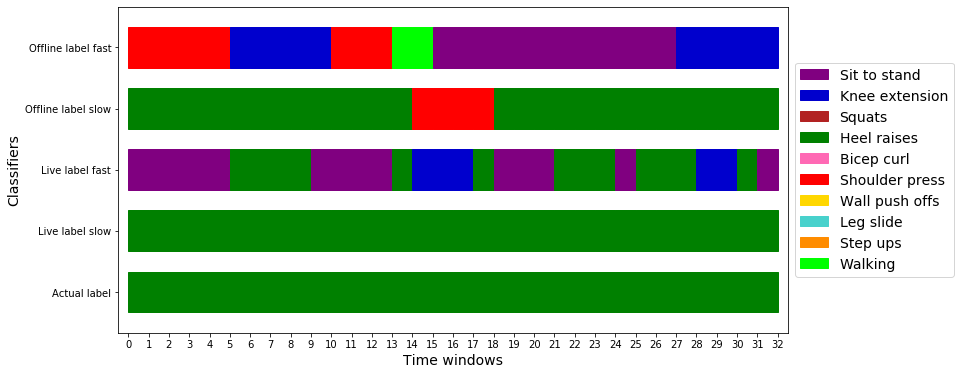

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 4
Fast pred = [4 4 4 4 4 4 4 4 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Slow pred = [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


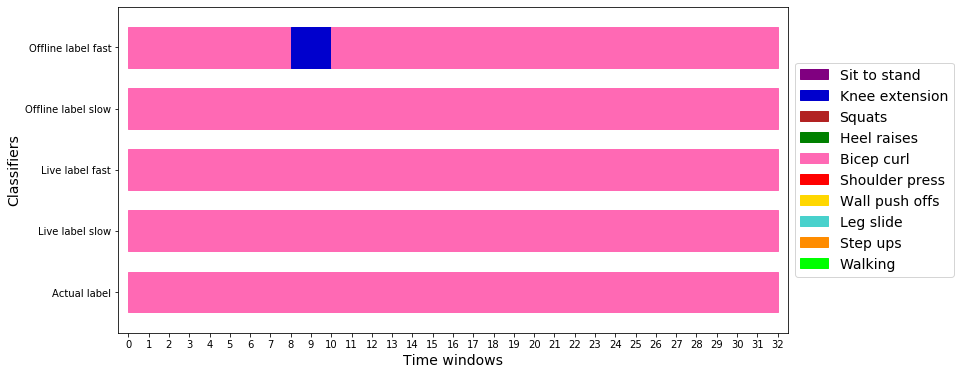

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 5
Fast pred = [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Slow pred = [5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


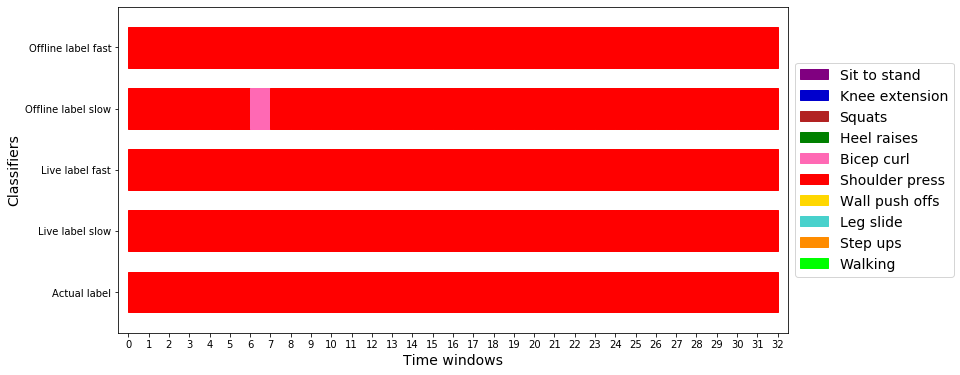

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 6
Fast pred = [6 6 6 0 0 7 7 0 0 0 1 6 6 1 7 0 0 0 0 1 6 6 7 7 0 0 1 0 0 0 1 6]
Slow pred = [6 6 6 6 6 6 6 6 6 1 6 6 6 1 6 1 6 1 1 1 6 6 6 1 1 1 1 1 1 1 1 6]


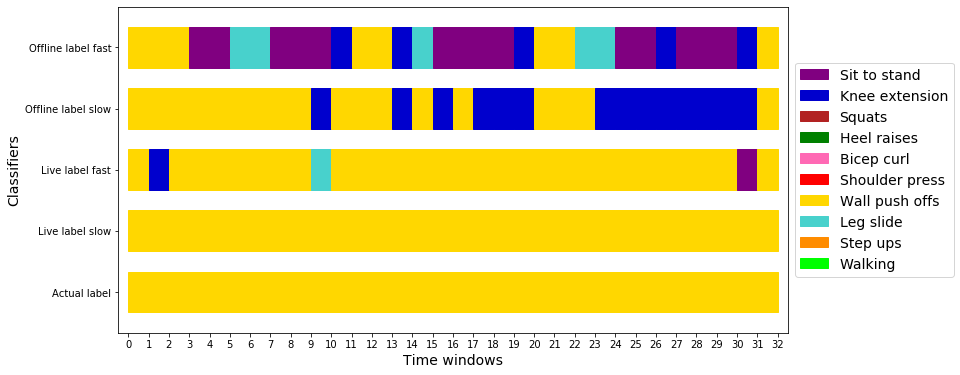

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 7
Fast pred = [6 7 6 6 6 6 6 6 6 6 7 6 1 1 6 6 6 2 1 7 7 7 7 7 7 7 7 7 7 6 6 7]
Slow pred = [7 7 7 1 1 1 0 0 0 7 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7 7 7 1 1 1 7]


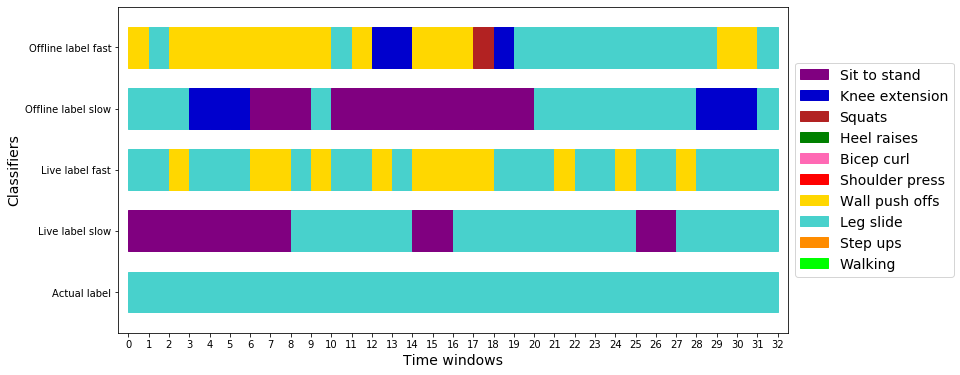

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Actual exercise = 8
Fast pred = [8 8 8 8 8 8 8 8 8 8 8 8 2 8 2 8 8 8 8 8 8 8 8 8 8 8 2 8 2 8 8]
Slow pred = [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


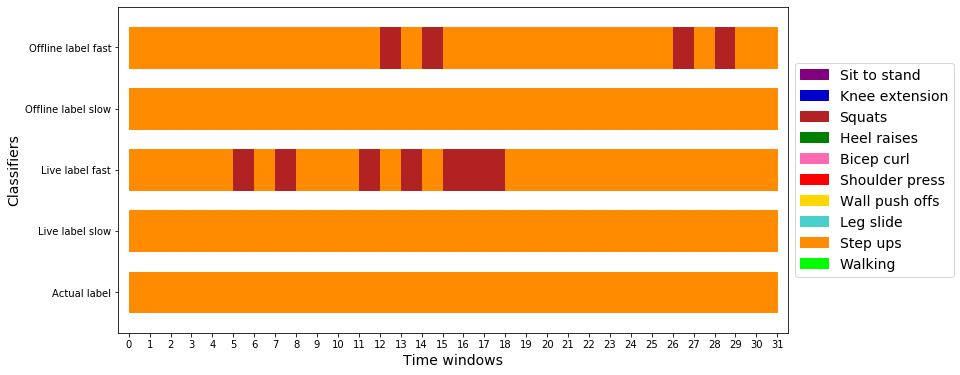

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/seb_fast_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


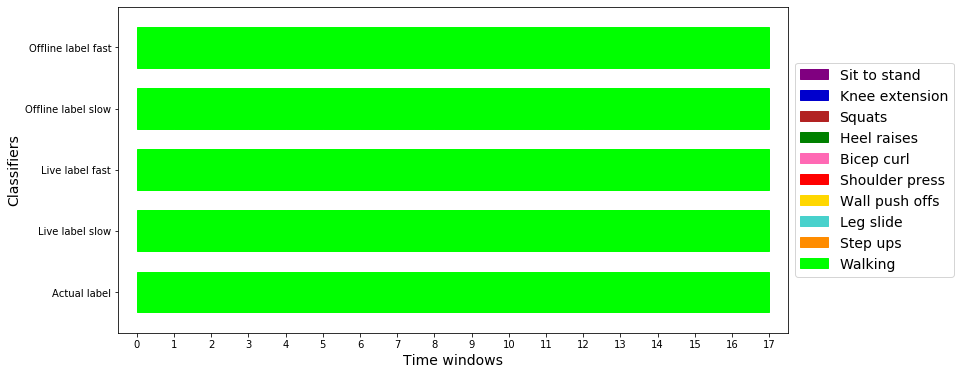

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



********************************************************************************
READING ../Validation/teo_slow_walk.csv
********************************************************************************


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Actual exercise = 9
Fast pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Slow pred = [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


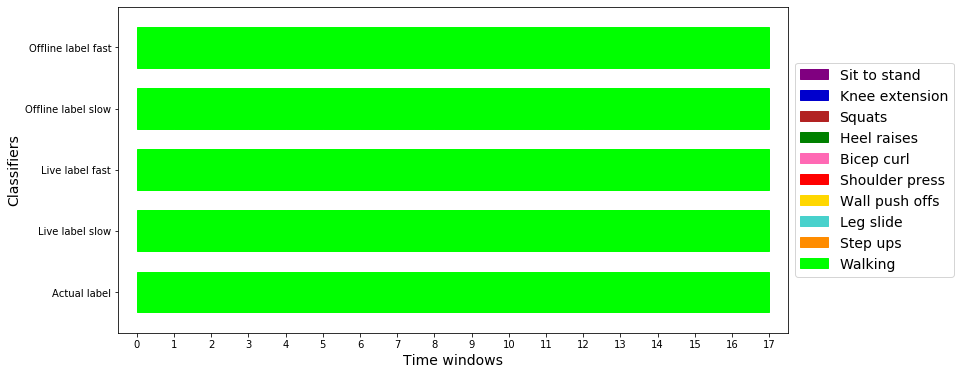

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [302]:
all_accs = get_accuracies_for_trials(file_list)

In [303]:
means = []
stds = []
for col in list(get_activity_name_dict().keys()):
    print("{} - mean = {}".format(col, all_accs[col].mean()))
    print("{} - std = {}".format(col, all_accs[col].std()))
    means.append(all_accs[col].mean())
    stds.append(all_accs[col].std())

stds =[i/10 for i in stds]

Sit to stand - mean = 0.9695578231292518
Sit to stand - std = 0.07319209566900471
Knee extension - mean = 0.8867984693877551
Knee extension - std = 0.1384020002831524
Squats - mean = 0.8075573979591838
Squats - std = 0.19278095970779488
Heel raises - mean = 0.7286352040816327
Heel raises - std = 0.3654364353742655
Bicep curl - mean = 0.9877232142857143
Bicep curl - std = 0.029876391900452402
Shoulder press - mean = 0.9933035714285714
Shoulder press - std = 0.017753502150965557
Wall push offs - mean = 0.7442602040816327
Wall push offs - std = 0.2920153435538213
Leg slide - mean = 0.47014380348913765
Leg slide - std = 0.23358934849155452
Step ups - mean = 0.9011010701400818
Step ups - std = 0.09970290279915708
Walking - mean = 0.8034313725490196
Walking - std = 0.36437733768493946


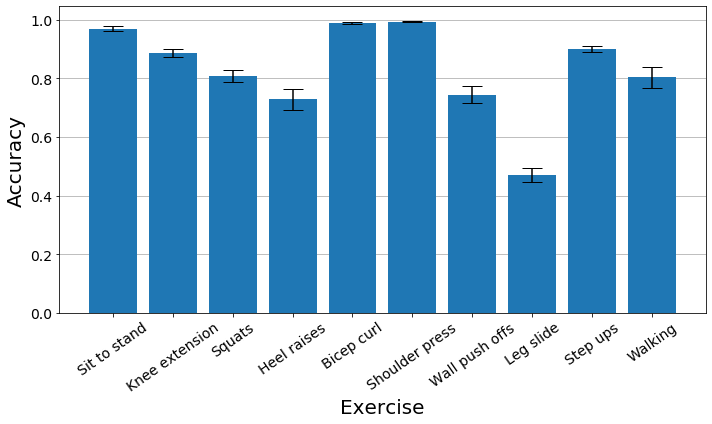

In [304]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.bar(range(len(means)), means, yerr=stds, capsize=10)
ax.yaxis.grid(True)
ax.set_axisbelow(True)

ax.set_xticks(range(10))
ax.set_xticklabels(list(get_activity_name_dict().keys()), rotation=35, fontsize=14)

# labels = [item.get_text() for item in ax.get_yticklabels()]
# print(labels)
ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)

ax.set_xlabel("Exercise", fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)

fig.tight_layout()

# Break it down by classifier

In [305]:
indices = ['online_fast', 'online_slow', 'offline_fast', 'offline_slow']
means = {'online_fast': [], 'online_slow': [], 'offline_fast':[], 'offline_slow': []}
stds = {'online_fast': [], 'online_slow': [], 'offline_fast':[], 'offline_slow': []}

for idx in indices:
    print("IDX = {}".format(idx))
    for col in list(get_activity_name_dict().keys()):
        print("{} - mean = {}".format(col, all_accs.loc[idx, col].mean()))
        print("{} - std = {}".format(col, all_accs.loc[idx, col].std()))
        means[idx].append(all_accs.loc[idx, col].mean())
        stds[idx].append(all_accs.loc[idx, col].std())

    stds[idx] =[i/10 for i in stds[idx]]

IDX = online_fast
Sit to stand - mean = 0.979591836734694
Sit to stand - std = 0.0539949247156039
Knee extension - mean = 0.8469387755102041
Knee extension - std = 0.11070211283749784
Squats - mean = 0.7340561224489797
Squats - std = 0.16294861264960647
Heel raises - mean = 0.6517857142857143
Heel raises - std = 0.3519054213780147
Bicep curl - mean = 1.0
Bicep curl - std = 0.0
Shoulder press - mean = 0.9955357142857143
Shoulder press - std = 0.01181138978153835
Wall push offs - mean = 0.8392857142857143
Wall push offs - std = 0.1823812340697812
Leg slide - mean = 0.49380760368663595
Leg slide - std = 0.2440099520465876
Step ups - mean = 0.8613770906953808
Step ups - std = 0.09493481337166587
Walking - mean = 0.6091503267973856
Walking - std = 0.4187860292175561
IDX = online_slow
Sit to stand - mean = 0.979591836734694
Sit to stand - std = 0.0539949247156039
Knee extension - mean = 0.9955357142857143
Knee extension - std = 0.01181138978153835
Squats - mean = 1.0
Squats - std = 0.0
Heel 

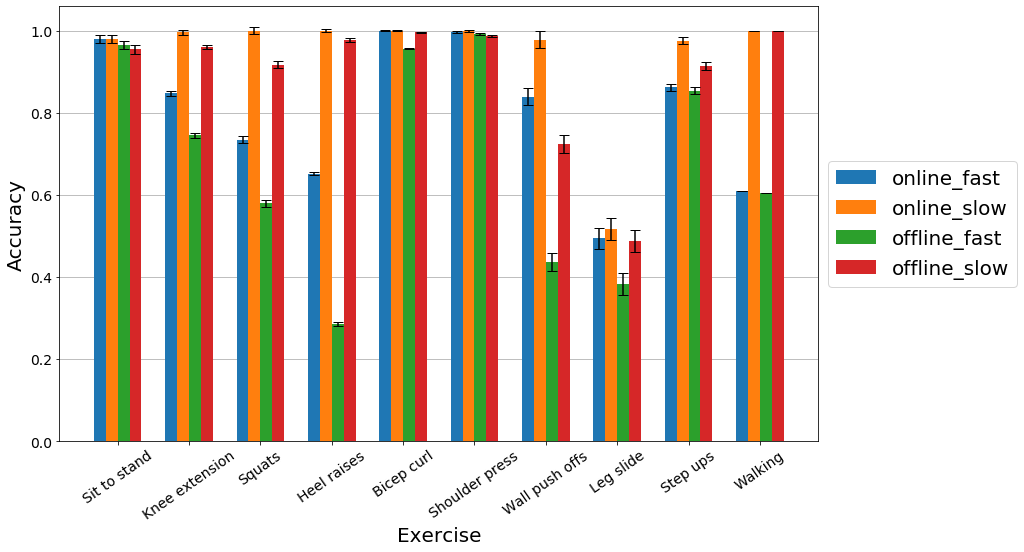

In [306]:
fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(111)

indices_plot = range(10)
width = np.min(np.diff(indices_plot))/6
w = 0.2
# w = width

ax.bar(indices_plot - 1.5*width, means['online_fast'], width, yerr=stds[idx], capsize=5, label='online_fast')
ax.bar(indices_plot - 0.5*width, means['online_slow'], width, yerr=stds[idx], capsize=5, label='online_slow')
ax.bar(indices_plot + 0.5*width, means['offline_fast'], width, yerr=stds[idx], capsize=5, label='offline_fast')
ax.bar(indices_plot + 1.5*width, means['offline_slow'], width, yerr=stds[idx], capsize=5, label='offline_slow')

ax.yaxis.grid(True)
ax.set_axisbelow(True)

ax.set_xticks(range(10))
ax.set_xticklabels(list(get_activity_name_dict().keys()), rotation=35, fontsize=14)

# labels = [item.get_text() for item in ax.get_yticklabels()]
# print(labels)
ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=14)

ax.set_xlabel("Exercise", fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

# fig.tight_layout()
plt.savefig("../Validation/accuracies_bar_plot.pdf")